# Architektur Neuronales Netz, Output x_H2 und x_NH3

In [1]:
# aNN Architektur

# Importe / Bibliotheken
import torch
from torch import nn
from torch.nn.functional import normalize as norm
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ReduceLROnPlateau
from sklearn.metrics import r2_score as r2
from sklearn.metrics import max_error
# from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_error as MAE
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, hidden4_size, hidden5_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            nn.SELU(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            nn.Linear(hidden1_size, hidden2_size),
            nn.SELU(),
            nn.Linear(hidden2_size, hidden3_size),
            nn.SELU(),
            nn.Linear(hidden3_size, hidden4_size),
            nn.SELU(),
            nn.Linear(hidden4_size, hidden5_size),
            nn.SELU(),
            nn.Linear(hidden5_size, output_size)
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 32, 64, 128, 64, 32, 2)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): Linear(in_features=5, out_features=32, bias=True)
    (1): SELU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): SELU()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): SELU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): SELU()
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): SELU()
    (10): Linear(in_features=32, out_features=2, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 64 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset_x.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs x[H2,N2,NH3]
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
x = torch.tensor(res['x'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000


# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = torch.stack((x[:,0], x[:,2]), 1) # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
#print(x_input.size())
# print(xi.size())

# Split des Datensatzes in Trainings und Testdaten
split = 0.8 # Anteil Trainingsdaten

x_input_train = x_input[:int(split * len(x_input)), :]
y_output_train = y_output[:int(split * len(y_output)), :]
x_input_test = x_input[int(split * len(x_input)):, :]
y_output_test = y_output[int(split * len(y_output)):, :]

# Preprocessing Normalisierung der Daten
mean_in = torch.mean(x_input_train,0) # Mittelwert
std_in = torch.std(x_input_train,0) # Standardabweichung
mean_out = torch.mean(y_output_train,0)
std_out = torch.std(y_output_train,0)

x_input_train_norm = (x_input_train - mean_in) / std_in
y_output_train_norm = (y_output_train - mean_out) / std_out

x_input_test_norm = (x_input_test - mean_in) / std_in
y_output_test_norm = (y_output_test - mean_out) / std_out

# print(x_input_train_norm)
# print(torch.mean(x_input_train_norm[:,0]))

# Tensoren zu einem großen Set gruppieren
train_dataset = TensorDataset(x_input_train_norm, y_output_train_norm)
test_dataset = TensorDataset(x_input_test_norm, y_output_test_norm)
    
# # Split in Trainings und Test Set
# train_dataset, test_dataset = random_split(dataset, 
#                                            [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
#                                            generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 32, 64, 128, 64, 32, 2)

# Loss Funktion; gibt Fehler an
loss_fn_MSE = nn.MSELoss()
loss_fn_L1 = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 0.02
#optimizer = torch.optim.SGD(net.parameters(), lr = learning_rate)
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 10, threshold = 1e-4)

In [7]:
# learning_rate = 1e-6
# optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, )

#### Funktion zur Bestimmung der Genauigkeit

In [8]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    MAE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn_MSE(pred, y) # Calculate the loss
            MRE += MRELoss(pred * std_out + mean_out, y * std_out + mean_out)
            MAE += loss_fn_L1(pred * std_out + mean_out, y * std_out + mean_out)
            
            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if ((pred[i,0] * std_out[0] + mean_out[0]) - (y[i,0] * std_out[0] + mean_out[0]) and (pred[i,1] * std_out[1] + mean_out[1]) - (y[i,1] * std_out[1] + mean_out[1])) <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        MAE /= num_batches

        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f}, MAE: {MAE:>8f} \n")

    net.train()
    
    return acc, loss, MRE, MAE

#### Training

In [9]:
num_epochs = 800 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []
train_MAE = []
test_MAE = []

#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn_MSE(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients  

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE, tr_MAE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    train_MAE.append(tr_MAE)
    
    scheduler.step(tr_loss) # LR scheduler step für reduceonPlateau
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE, t_MAE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)
    test_MAE.append(t_MAE)

Epoch 1/800, Iteration 1/12, Loss: 1.1327
Epoch 1/800, Iteration 2/12, Loss: 1.2397
Epoch 1/800, Iteration 3/12, Loss: 1.8192
Epoch 1/800, Iteration 4/12, Loss: 1.2587
Epoch 1/800, Iteration 5/12, Loss: 0.4406
Epoch 1/800, Iteration 6/12, Loss: 0.6542
Epoch 1/800, Iteration 7/12, Loss: 0.6495
Epoch 1/800, Iteration 8/12, Loss: 0.6546
Epoch 1/800, Iteration 9/12, Loss: 0.5088
Epoch 1/800, Iteration 10/12, Loss: 0.4569
Epoch 1/800, Iteration 11/12, Loss: 0.3976
Epoch 1/800, Iteration 12/12, Loss: 0.2643
Epoch 1/800, Iteration 13/12, Loss: 0.1913
Train Error: 
 Accuracy: 77.38%, Avg loss: 0.198733, MRE: 0.187411, MAE: 0.049268 

Test Error: 
 Accuracy: 75.5%, Avg loss: 0.161341, MRE: 0.154556, MAE: 0.043659 

Epoch 2/800, Iteration 1/12, Loss: 0.1716
Epoch 2/800, Iteration 2/12, Loss: 0.2185
Epoch 2/800, Iteration 3/12, Loss: 0.1802
Epoch 2/800, Iteration 4/12, Loss: 0.1480
Epoch 2/800, Iteration 5/12, Loss: 0.1709
Epoch 2/800, Iteration 6/12, Loss: 0.1894
Epoch 2/800, Iteration 7/12, Los

Epoch 12/800, Iteration 11/12, Loss: 0.0038
Epoch 12/800, Iteration 12/12, Loss: 0.0056
Epoch 12/800, Iteration 13/12, Loss: 0.0055
Train Error: 
 Accuracy: 93.5%, Avg loss: 0.005489, MRE: 0.049021, MAE: 0.008266 

Test Error: 
 Accuracy: 93.5%, Avg loss: 0.004426, MRE: 0.041426, MAE: 0.007511 

Epoch 13/800, Iteration 1/12, Loss: 0.0060
Epoch 13/800, Iteration 2/12, Loss: 0.0043
Epoch 13/800, Iteration 3/12, Loss: 0.0029
Epoch 13/800, Iteration 4/12, Loss: 0.0076
Epoch 13/800, Iteration 5/12, Loss: 0.0033
Epoch 13/800, Iteration 6/12, Loss: 0.0059
Epoch 13/800, Iteration 7/12, Loss: 0.0038
Epoch 13/800, Iteration 8/12, Loss: 0.0036
Epoch 13/800, Iteration 9/12, Loss: 0.0044
Epoch 13/800, Iteration 10/12, Loss: 0.0059
Epoch 13/800, Iteration 11/12, Loss: 0.0062
Epoch 13/800, Iteration 12/12, Loss: 0.0031
Epoch 13/800, Iteration 13/12, Loss: 0.0052
Train Error: 
 Accuracy: 99.62%, Avg loss: 0.009940, MRE: 0.048590, MAE: 0.010185 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.008183, MRE: 

Epoch 24/800, Iteration 7/12, Loss: 0.0185
Epoch 24/800, Iteration 8/12, Loss: 0.0189
Epoch 24/800, Iteration 9/12, Loss: 0.0129
Epoch 24/800, Iteration 10/12, Loss: 0.0200
Epoch 24/800, Iteration 11/12, Loss: 0.0240
Epoch 24/800, Iteration 12/12, Loss: 0.0158
Epoch 24/800, Iteration 13/12, Loss: 0.0162
Train Error: 
 Accuracy: 75.62%, Avg loss: 0.018619, MRE: 0.069133, MAE: 0.012523 

Test Error: 
 Accuracy: 73.0%, Avg loss: 0.016711, MRE: 0.065264, MAE: 0.012192 

Epoch 25/800, Iteration 1/12, Loss: 0.0159
Epoch 25/800, Iteration 2/12, Loss: 0.0307
Epoch 25/800, Iteration 3/12, Loss: 0.0184
Epoch 25/800, Iteration 4/12, Loss: 0.0224
Epoch 25/800, Iteration 5/12, Loss: 0.0179
Epoch 25/800, Iteration 6/12, Loss: 0.0225
Epoch 25/800, Iteration 7/12, Loss: 0.0148
Epoch 25/800, Iteration 8/12, Loss: 0.0111
Epoch 25/800, Iteration 9/12, Loss: 0.0080
Epoch 25/800, Iteration 10/12, Loss: 0.0060
Epoch 25/800, Iteration 11/12, Loss: 0.0168
Epoch 25/800, Iteration 12/12, Loss: 0.0094
Epoch 25/8

Train Error: 
 Accuracy: 98.75%, Avg loss: 0.001343, MRE: 0.019969, MAE: 0.003368 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001239, MRE: 0.018556, MAE: 0.003638 

Epoch 36/800, Iteration 1/12, Loss: 0.0009
Epoch 36/800, Iteration 2/12, Loss: 0.0019
Epoch 36/800, Iteration 3/12, Loss: 0.0010
Epoch 36/800, Iteration 4/12, Loss: 0.0011
Epoch 36/800, Iteration 5/12, Loss: 0.0014
Epoch 36/800, Iteration 6/12, Loss: 0.0013
Epoch 36/800, Iteration 7/12, Loss: 0.0020
Epoch 36/800, Iteration 8/12, Loss: 0.0021
Epoch 36/800, Iteration 9/12, Loss: 0.0011
Epoch 36/800, Iteration 10/12, Loss: 0.0011
Epoch 36/800, Iteration 11/12, Loss: 0.0009
Epoch 36/800, Iteration 12/12, Loss: 0.0014
Epoch 36/800, Iteration 13/12, Loss: 0.0016
Train Error: 
 Accuracy: 99.25%, Avg loss: 0.001145, MRE: 0.019608, MAE: 0.003137 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.001221, MRE: 0.018212, MAE: 0.003482 

Epoch 37/800, Iteration 1/12, Loss: 0.0008
Epoch 37/800, Iteration 2/12, Loss: 0.0020
Epoch 37/800, Iter

Epoch 47/800, Iteration 9/12, Loss: 0.0005
Epoch 47/800, Iteration 10/12, Loss: 0.0010
Epoch 47/800, Iteration 11/12, Loss: 0.0007
Epoch 47/800, Iteration 12/12, Loss: 0.0006
Epoch 47/800, Iteration 13/12, Loss: 0.0012
Train Error: 
 Accuracy: 99.5%, Avg loss: 0.000670, MRE: 0.016525, MAE: 0.002522 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000725, MRE: 0.014565, MAE: 0.002724 

Epoch 48/800, Iteration 1/12, Loss: 0.0006
Epoch 48/800, Iteration 2/12, Loss: 0.0006
Epoch 48/800, Iteration 3/12, Loss: 0.0005
Epoch 48/800, Iteration 4/12, Loss: 0.0007
Epoch 48/800, Iteration 5/12, Loss: 0.0004
Epoch 48/800, Iteration 6/12, Loss: 0.0007
Epoch 48/800, Iteration 7/12, Loss: 0.0011
Epoch 48/800, Iteration 8/12, Loss: 0.0005
Epoch 48/800, Iteration 9/12, Loss: 0.0007
Epoch 48/800, Iteration 10/12, Loss: 0.0008
Epoch 48/800, Iteration 11/12, Loss: 0.0012
Epoch 48/800, Iteration 12/12, Loss: 0.0007
Epoch 48/800, Iteration 13/12, Loss: 0.0006
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.000662,

Train Error: 
 Accuracy: 99.88%, Avg loss: 0.000477, MRE: 0.014684, MAE: 0.002193 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000527, MRE: 0.011985, MAE: 0.002284 

Epoch 59/800, Iteration 1/12, Loss: 0.0005
Epoch 59/800, Iteration 2/12, Loss: 0.0004
Epoch 59/800, Iteration 3/12, Loss: 0.0005
Epoch 59/800, Iteration 4/12, Loss: 0.0007
Epoch 59/800, Iteration 5/12, Loss: 0.0005
Epoch 59/800, Iteration 6/12, Loss: 0.0004
Epoch 59/800, Iteration 7/12, Loss: 0.0005
Epoch 59/800, Iteration 8/12, Loss: 0.0004
Epoch 59/800, Iteration 9/12, Loss: 0.0006
Epoch 59/800, Iteration 10/12, Loss: 0.0005
Epoch 59/800, Iteration 11/12, Loss: 0.0004
Epoch 59/800, Iteration 12/12, Loss: 0.0006
Epoch 59/800, Iteration 13/12, Loss: 0.0005
Train Error: 
 Accuracy: 99.88%, Avg loss: 0.000476, MRE: 0.014625, MAE: 0.002168 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000531, MRE: 0.012086, MAE: 0.002278 

Epoch 60/800, Iteration 1/12, Loss: 0.0008
Epoch 60/800, Iteration 2/12, Loss: 0.0005
Epoch 60/800, Ite

Epoch 70/800, Iteration 9/12, Loss: 0.0004
Epoch 70/800, Iteration 10/12, Loss: 0.0003
Epoch 70/800, Iteration 11/12, Loss: 0.0003
Epoch 70/800, Iteration 12/12, Loss: 0.0006
Epoch 70/800, Iteration 13/12, Loss: 0.0004
Train Error: 
 Accuracy: 99.88%, Avg loss: 0.000385, MRE: 0.014268, MAE: 0.002005 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000458, MRE: 0.010779, MAE: 0.002140 

Epoch 71/800, Iteration 1/12, Loss: 0.0004
Epoch 71/800, Iteration 2/12, Loss: 0.0004
Epoch 71/800, Iteration 3/12, Loss: 0.0005
Epoch 71/800, Iteration 4/12, Loss: 0.0004
Epoch 71/800, Iteration 5/12, Loss: 0.0003
Epoch 71/800, Iteration 6/12, Loss: 0.0005
Epoch 71/800, Iteration 7/12, Loss: 0.0005
Epoch 71/800, Iteration 8/12, Loss: 0.0005
Epoch 71/800, Iteration 9/12, Loss: 0.0004
Epoch 71/800, Iteration 10/12, Loss: 0.0004
Epoch 71/800, Iteration 11/12, Loss: 0.0003
Epoch 71/800, Iteration 12/12, Loss: 0.0003
Epoch 71/800, Iteration 13/12, Loss: 0.0003
Train Error: 
 Accuracy: 99.88%, Avg loss: 0.000391

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000328, MRE: 0.012335, MAE: 0.001866 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000409, MRE: 0.010772, MAE: 0.002010 

Epoch 82/800, Iteration 1/12, Loss: 0.0003
Epoch 82/800, Iteration 2/12, Loss: 0.0003
Epoch 82/800, Iteration 3/12, Loss: 0.0004
Epoch 82/800, Iteration 4/12, Loss: 0.0003
Epoch 82/800, Iteration 5/12, Loss: 0.0004
Epoch 82/800, Iteration 6/12, Loss: 0.0006
Epoch 82/800, Iteration 7/12, Loss: 0.0003
Epoch 82/800, Iteration 8/12, Loss: 0.0003
Epoch 82/800, Iteration 9/12, Loss: 0.0003
Epoch 82/800, Iteration 10/12, Loss: 0.0003
Epoch 82/800, Iteration 11/12, Loss: 0.0004
Epoch 82/800, Iteration 12/12, Loss: 0.0003
Epoch 82/800, Iteration 13/12, Loss: 0.0005
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000312, MRE: 0.012656, MAE: 0.001855 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000423, MRE: 0.010608, MAE: 0.002105 

Epoch 83/800, Iteration 1/12, Loss: 0.0004
Epoch 83/800, Iteration 2/12, Loss: 0.0003
Epoch 83/800, Ite

Epoch 93/800, Iteration 10/12, Loss: 0.0002
Epoch 93/800, Iteration 11/12, Loss: 0.0003
Epoch 93/800, Iteration 12/12, Loss: 0.0002
Epoch 93/800, Iteration 13/12, Loss: 0.0003
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000342, MRE: 0.013239, MAE: 0.001875 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000373, MRE: 0.009416, MAE: 0.001936 

Epoch 94/800, Iteration 1/12, Loss: 0.0003
Epoch 94/800, Iteration 2/12, Loss: 0.0003
Epoch 94/800, Iteration 3/12, Loss: 0.0002
Epoch 94/800, Iteration 4/12, Loss: 0.0002
Epoch 94/800, Iteration 5/12, Loss: 0.0003
Epoch 94/800, Iteration 6/12, Loss: 0.0003
Epoch 94/800, Iteration 7/12, Loss: 0.0003
Epoch 94/800, Iteration 8/12, Loss: 0.0003
Epoch 94/800, Iteration 9/12, Loss: 0.0003
Epoch 94/800, Iteration 10/12, Loss: 0.0003
Epoch 94/800, Iteration 11/12, Loss: 0.0003
Epoch 94/800, Iteration 12/12, Loss: 0.0002
Epoch 94/800, Iteration 13/12, Loss: 0.0003
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000266, MRE: 0.011664, MAE: 0.001708 

Test Error

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000325, MRE: 0.012389, MAE: 0.001985 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000442, MRE: 0.010086, MAE: 0.002256 

Epoch 105/800, Iteration 1/12, Loss: 0.0003
Epoch 105/800, Iteration 2/12, Loss: 0.0003
Epoch 105/800, Iteration 3/12, Loss: 0.0003
Epoch 105/800, Iteration 4/12, Loss: 0.0002
Epoch 105/800, Iteration 5/12, Loss: 0.0003
Epoch 105/800, Iteration 6/12, Loss: 0.0003
Epoch 105/800, Iteration 7/12, Loss: 0.0003
Epoch 105/800, Iteration 8/12, Loss: 0.0003
Epoch 105/800, Iteration 9/12, Loss: 0.0003
Epoch 105/800, Iteration 10/12, Loss: 0.0002
Epoch 105/800, Iteration 11/12, Loss: 0.0003
Epoch 105/800, Iteration 12/12, Loss: 0.0003
Epoch 105/800, Iteration 13/12, Loss: 0.0002
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000261, MRE: 0.010973, MAE: 0.001674 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000346, MRE: 0.009394, MAE: 0.001913 

Epoch 106/800, Iteration 1/12, Loss: 0.0003
Epoch 106/800, Iteration 2/12, Loss: 0.0002
Ep

Epoch 116/800, Iteration 10/12, Loss: 0.0002
Epoch 116/800, Iteration 11/12, Loss: 0.0002
Epoch 116/800, Iteration 12/12, Loss: 0.0002
Epoch 116/800, Iteration 13/12, Loss: 0.0003
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000279, MRE: 0.011418, MAE: 0.001770 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000351, MRE: 0.009196, MAE: 0.001987 

Epoch 117/800, Iteration 1/12, Loss: 0.0002
Epoch 117/800, Iteration 2/12, Loss: 0.0003
Epoch 117/800, Iteration 3/12, Loss: 0.0002
Epoch 117/800, Iteration 4/12, Loss: 0.0002
Epoch 117/800, Iteration 5/12, Loss: 0.0003
Epoch 117/800, Iteration 6/12, Loss: 0.0003
Epoch 117/800, Iteration 7/12, Loss: 0.0002
Epoch 117/800, Iteration 8/12, Loss: 0.0002
Epoch 117/800, Iteration 9/12, Loss: 0.0003
Epoch 117/800, Iteration 10/12, Loss: 0.0003
Epoch 117/800, Iteration 11/12, Loss: 0.0002
Epoch 117/800, Iteration 12/12, Loss: 0.0002
Epoch 117/800, Iteration 13/12, Loss: 0.0002
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000269, MRE: 0.010707, MAE: 0.00

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000194, MRE: 0.009891, MAE: 0.001456 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000299, MRE: 0.008329, MAE: 0.001779 

Epoch 128/800, Iteration 1/12, Loss: 0.0002
Epoch 128/800, Iteration 2/12, Loss: 0.0002
Epoch 128/800, Iteration 3/12, Loss: 0.0002
Epoch 128/800, Iteration 4/12, Loss: 0.0002
Epoch 128/800, Iteration 5/12, Loss: 0.0002
Epoch 128/800, Iteration 6/12, Loss: 0.0002
Epoch 128/800, Iteration 7/12, Loss: 0.0001
Epoch 128/800, Iteration 8/12, Loss: 0.0002
Epoch 128/800, Iteration 9/12, Loss: 0.0002
Epoch 128/800, Iteration 10/12, Loss: 0.0002
Epoch 128/800, Iteration 11/12, Loss: 0.0002
Epoch 128/800, Iteration 12/12, Loss: 0.0002
Epoch 128/800, Iteration 13/12, Loss: 0.0002
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000194, MRE: 0.009772, MAE: 0.001468 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000286, MRE: 0.008855, MAE: 0.001781 

Epoch 129/800, Iteration 1/12, Loss: 0.0002
Epoch 129/800, Iteration 2/12, Loss: 0.0002
Ep

Epoch 139/800, Iteration 10/12, Loss: 0.0003
Epoch 139/800, Iteration 11/12, Loss: 0.0003
Epoch 139/800, Iteration 12/12, Loss: 0.0003
Epoch 139/800, Iteration 13/12, Loss: 0.0002
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.010198, MAE: 0.001716 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000333, MRE: 0.009006, MAE: 0.001944 

Epoch 140/800, Iteration 1/12, Loss: 0.0003
Epoch 140/800, Iteration 2/12, Loss: 0.0003
Epoch 140/800, Iteration 3/12, Loss: 0.0003
Epoch 140/800, Iteration 4/12, Loss: 0.0002
Epoch 140/800, Iteration 5/12, Loss: 0.0003
Epoch 140/800, Iteration 6/12, Loss: 0.0003
Epoch 140/800, Iteration 7/12, Loss: 0.0002
Epoch 140/800, Iteration 8/12, Loss: 0.0002
Epoch 140/800, Iteration 9/12, Loss: 0.0002
Epoch 140/800, Iteration 10/12, Loss: 0.0002
Epoch 140/800, Iteration 11/12, Loss: 0.0002
Epoch 140/800, Iteration 12/12, Loss: 0.0002
Epoch 140/800, Iteration 13/12, Loss: 0.0002
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000170, MRE: 0.009429, MAE: 0.00

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000133, MRE: 0.008639, MAE: 0.001211 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000232, MRE: 0.007591, MAE: 0.001563 

Epoch 151/800, Iteration 1/12, Loss: 0.0002
Epoch 151/800, Iteration 2/12, Loss: 0.0001
Epoch 151/800, Iteration 3/12, Loss: 0.0001
Epoch 151/800, Iteration 4/12, Loss: 0.0001
Epoch 151/800, Iteration 5/12, Loss: 0.0001
Epoch 151/800, Iteration 6/12, Loss: 0.0001
Epoch 151/800, Iteration 7/12, Loss: 0.0002
Epoch 151/800, Iteration 8/12, Loss: 0.0001
Epoch 151/800, Iteration 9/12, Loss: 0.0001
Epoch 151/800, Iteration 10/12, Loss: 0.0001
Epoch 151/800, Iteration 11/12, Loss: 0.0001
Epoch 151/800, Iteration 12/12, Loss: 0.0001
Epoch 151/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000134, MRE: 0.008719, MAE: 0.001223 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000231, MRE: 0.007570, MAE: 0.001558 

Epoch 152/800, Iteration 1/12, Loss: 0.0001
Epoch 152/800, Iteration 2/12, Loss: 0.0001
Ep

Epoch 162/800, Iteration 12/12, Loss: 0.0001
Epoch 162/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000132, MRE: 0.008589, MAE: 0.001211 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000231, MRE: 0.007557, MAE: 0.001561 

Epoch 163/800, Iteration 1/12, Loss: 0.0001
Epoch 163/800, Iteration 2/12, Loss: 0.0001
Epoch 163/800, Iteration 3/12, Loss: 0.0002
Epoch 163/800, Iteration 4/12, Loss: 0.0001
Epoch 163/800, Iteration 5/12, Loss: 0.0001
Epoch 163/800, Iteration 6/12, Loss: 0.0001
Epoch 163/800, Iteration 7/12, Loss: 0.0001
Epoch 163/800, Iteration 8/12, Loss: 0.0001
Epoch 163/800, Iteration 9/12, Loss: 0.0001
Epoch 163/800, Iteration 10/12, Loss: 0.0001
Epoch 163/800, Iteration 11/12, Loss: 0.0002
Epoch 163/800, Iteration 12/12, Loss: 0.0001
Epoch 163/800, Iteration 13/12, Loss: 0.0002
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000132, MRE: 0.008587, MAE: 0.001210 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000227, MRE: 0.007518, MAE: 0.001540 



Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000130, MRE: 0.008576, MAE: 0.001198 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007485, MAE: 0.001547 

Epoch 174/800, Iteration 1/12, Loss: 0.0001
Epoch 174/800, Iteration 2/12, Loss: 0.0001
Epoch 174/800, Iteration 3/12, Loss: 0.0001
Epoch 174/800, Iteration 4/12, Loss: 0.0001
Epoch 174/800, Iteration 5/12, Loss: 0.0001
Epoch 174/800, Iteration 6/12, Loss: 0.0001
Epoch 174/800, Iteration 7/12, Loss: 0.0001
Epoch 174/800, Iteration 8/12, Loss: 0.0002
Epoch 174/800, Iteration 9/12, Loss: 0.0001
Epoch 174/800, Iteration 10/12, Loss: 0.0002
Epoch 174/800, Iteration 11/12, Loss: 0.0001
Epoch 174/800, Iteration 12/12, Loss: 0.0001
Epoch 174/800, Iteration 13/12, Loss: 0.0002
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000131, MRE: 0.008648, MAE: 0.001205 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007481, MAE: 0.001546 

Epoch 175/800, Iteration 1/12, Loss: 0.0001
Epoch 175/800, Iteration 2/12, Loss: 0.0001
Ep

Epoch 185/800, Iteration 11/12, Loss: 0.0002
Epoch 185/800, Iteration 12/12, Loss: 0.0001
Epoch 185/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000130, MRE: 0.008549, MAE: 0.001206 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007529, MAE: 0.001547 

Epoch 186/800, Iteration 1/12, Loss: 0.0002
Epoch 186/800, Iteration 2/12, Loss: 0.0001
Epoch 186/800, Iteration 3/12, Loss: 0.0001
Epoch 186/800, Iteration 4/12, Loss: 0.0001
Epoch 186/800, Iteration 5/12, Loss: 0.0001
Epoch 186/800, Iteration 6/12, Loss: 0.0001
Epoch 186/800, Iteration 7/12, Loss: 0.0001
Epoch 186/800, Iteration 8/12, Loss: 0.0002
Epoch 186/800, Iteration 9/12, Loss: 0.0001
Epoch 186/800, Iteration 10/12, Loss: 0.0001
Epoch 186/800, Iteration 11/12, Loss: 0.0001
Epoch 186/800, Iteration 12/12, Loss: 0.0001
Epoch 186/800, Iteration 13/12, Loss: 0.0002
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000132, MRE: 0.008643, MAE: 0.001211 

Test Error: 
 Accuracy: 100.0%, Avg lo

Epoch 196/800, Iteration 12/12, Loss: 0.0001
Epoch 196/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000130, MRE: 0.008574, MAE: 0.001199 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007509, MAE: 0.001546 

Epoch 197/800, Iteration 1/12, Loss: 0.0001
Epoch 197/800, Iteration 2/12, Loss: 0.0002
Epoch 197/800, Iteration 3/12, Loss: 0.0002
Epoch 197/800, Iteration 4/12, Loss: 0.0001
Epoch 197/800, Iteration 5/12, Loss: 0.0001
Epoch 197/800, Iteration 6/12, Loss: 0.0001
Epoch 197/800, Iteration 7/12, Loss: 0.0001
Epoch 197/800, Iteration 8/12, Loss: 0.0001
Epoch 197/800, Iteration 9/12, Loss: 0.0001
Epoch 197/800, Iteration 10/12, Loss: 0.0001
Epoch 197/800, Iteration 11/12, Loss: 0.0001
Epoch 197/800, Iteration 12/12, Loss: 0.0001
Epoch 197/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000132, MRE: 0.008704, MAE: 0.001212 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001545 



Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000131, MRE: 0.008587, MAE: 0.001210 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007508, MAE: 0.001546 

Epoch 208/800, Iteration 1/12, Loss: 0.0001
Epoch 208/800, Iteration 2/12, Loss: 0.0001
Epoch 208/800, Iteration 3/12, Loss: 0.0001
Epoch 208/800, Iteration 4/12, Loss: 0.0001
Epoch 208/800, Iteration 5/12, Loss: 0.0001
Epoch 208/800, Iteration 6/12, Loss: 0.0001
Epoch 208/800, Iteration 7/12, Loss: 0.0001
Epoch 208/800, Iteration 8/12, Loss: 0.0001
Epoch 208/800, Iteration 9/12, Loss: 0.0001
Epoch 208/800, Iteration 10/12, Loss: 0.0001
Epoch 208/800, Iteration 11/12, Loss: 0.0001
Epoch 208/800, Iteration 12/12, Loss: 0.0002
Epoch 208/800, Iteration 13/12, Loss: 0.0002
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000132, MRE: 0.008685, MAE: 0.001208 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007508, MAE: 0.001546 

Epoch 209/800, Iteration 1/12, Loss: 0.0002
Epoch 209/800, Iteration 2/12, Loss: 0.0001
Ep

Epoch 219/800, Iteration 11/12, Loss: 0.0001
Epoch 219/800, Iteration 12/12, Loss: 0.0001
Epoch 219/800, Iteration 13/12, Loss: 0.0002
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000131, MRE: 0.008598, MAE: 0.001209 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007508, MAE: 0.001546 

Epoch 220/800, Iteration 1/12, Loss: 0.0001
Epoch 220/800, Iteration 2/12, Loss: 0.0002
Epoch 220/800, Iteration 3/12, Loss: 0.0002
Epoch 220/800, Iteration 4/12, Loss: 0.0002
Epoch 220/800, Iteration 5/12, Loss: 0.0001
Epoch 220/800, Iteration 6/12, Loss: 0.0001
Epoch 220/800, Iteration 7/12, Loss: 0.0001
Epoch 220/800, Iteration 8/12, Loss: 0.0001
Epoch 220/800, Iteration 9/12, Loss: 0.0001
Epoch 220/800, Iteration 10/12, Loss: 0.0001
Epoch 220/800, Iteration 11/12, Loss: 0.0001
Epoch 220/800, Iteration 12/12, Loss: 0.0001
Epoch 220/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000130, MRE: 0.008558, MAE: 0.001202 

Test Error: 
 Accuracy: 100.0%, Avg lo

Epoch 230/800, Iteration 12/12, Loss: 0.0001
Epoch 230/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000130, MRE: 0.008640, MAE: 0.001204 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001546 

Epoch 231/800, Iteration 1/12, Loss: 0.0002
Epoch 231/800, Iteration 2/12, Loss: 0.0001
Epoch 231/800, Iteration 3/12, Loss: 0.0001
Epoch 231/800, Iteration 4/12, Loss: 0.0001
Epoch 231/800, Iteration 5/12, Loss: 0.0001
Epoch 231/800, Iteration 6/12, Loss: 0.0001
Epoch 231/800, Iteration 7/12, Loss: 0.0002
Epoch 231/800, Iteration 8/12, Loss: 0.0001
Epoch 231/800, Iteration 9/12, Loss: 0.0001
Epoch 231/800, Iteration 10/12, Loss: 0.0001
Epoch 231/800, Iteration 11/12, Loss: 0.0001
Epoch 231/800, Iteration 12/12, Loss: 0.0001
Epoch 231/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000130, MRE: 0.008566, MAE: 0.001203 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001546 



Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000130, MRE: 0.008565, MAE: 0.001204 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001546 

Epoch 242/800, Iteration 1/12, Loss: 0.0001
Epoch 242/800, Iteration 2/12, Loss: 0.0002
Epoch 242/800, Iteration 3/12, Loss: 0.0001
Epoch 242/800, Iteration 4/12, Loss: 0.0001
Epoch 242/800, Iteration 5/12, Loss: 0.0001
Epoch 242/800, Iteration 6/12, Loss: 0.0001
Epoch 242/800, Iteration 7/12, Loss: 0.0001
Epoch 242/800, Iteration 8/12, Loss: 0.0002
Epoch 242/800, Iteration 9/12, Loss: 0.0002
Epoch 242/800, Iteration 10/12, Loss: 0.0001
Epoch 242/800, Iteration 11/12, Loss: 0.0001
Epoch 242/800, Iteration 12/12, Loss: 0.0001
Epoch 242/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000131, MRE: 0.008691, MAE: 0.001208 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001546 

Epoch 243/800, Iteration 1/12, Loss: 0.0001
Epoch 243/800, Iteration 2/12, Loss: 0.0001
Ep

Epoch 253/800, Iteration 10/12, Loss: 0.0002
Epoch 253/800, Iteration 11/12, Loss: 0.0001
Epoch 253/800, Iteration 12/12, Loss: 0.0001
Epoch 253/800, Iteration 13/12, Loss: 0.0002
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000129, MRE: 0.008525, MAE: 0.001198 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001546 

Epoch 254/800, Iteration 1/12, Loss: 0.0001
Epoch 254/800, Iteration 2/12, Loss: 0.0001
Epoch 254/800, Iteration 3/12, Loss: 0.0001
Epoch 254/800, Iteration 4/12, Loss: 0.0001
Epoch 254/800, Iteration 5/12, Loss: 0.0001
Epoch 254/800, Iteration 6/12, Loss: 0.0001
Epoch 254/800, Iteration 7/12, Loss: 0.0001
Epoch 254/800, Iteration 8/12, Loss: 0.0001
Epoch 254/800, Iteration 9/12, Loss: 0.0001
Epoch 254/800, Iteration 10/12, Loss: 0.0001
Epoch 254/800, Iteration 11/12, Loss: 0.0001
Epoch 254/800, Iteration 12/12, Loss: 0.0002
Epoch 254/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000131, MRE: 0.008599, MAE: 0.00

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000131, MRE: 0.008675, MAE: 0.001206 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001546 

Epoch 265/800, Iteration 1/12, Loss: 0.0001
Epoch 265/800, Iteration 2/12, Loss: 0.0001
Epoch 265/800, Iteration 3/12, Loss: 0.0001
Epoch 265/800, Iteration 4/12, Loss: 0.0002
Epoch 265/800, Iteration 5/12, Loss: 0.0001
Epoch 265/800, Iteration 6/12, Loss: 0.0001
Epoch 265/800, Iteration 7/12, Loss: 0.0001
Epoch 265/800, Iteration 8/12, Loss: 0.0001
Epoch 265/800, Iteration 9/12, Loss: 0.0001
Epoch 265/800, Iteration 10/12, Loss: 0.0002
Epoch 265/800, Iteration 11/12, Loss: 0.0001
Epoch 265/800, Iteration 12/12, Loss: 0.0001
Epoch 265/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000132, MRE: 0.008639, MAE: 0.001212 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001546 

Epoch 266/800, Iteration 1/12, Loss: 0.0001
Epoch 266/800, Iteration 2/12, Loss: 0.0001
Ep

Epoch 276/800, Iteration 11/12, Loss: 0.0001
Epoch 276/800, Iteration 12/12, Loss: 0.0001
Epoch 276/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000129, MRE: 0.008532, MAE: 0.001199 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001546 

Epoch 277/800, Iteration 1/12, Loss: 0.0001
Epoch 277/800, Iteration 2/12, Loss: 0.0001
Epoch 277/800, Iteration 3/12, Loss: 0.0001
Epoch 277/800, Iteration 4/12, Loss: 0.0001
Epoch 277/800, Iteration 5/12, Loss: 0.0001
Epoch 277/800, Iteration 6/12, Loss: 0.0001
Epoch 277/800, Iteration 7/12, Loss: 0.0001
Epoch 277/800, Iteration 8/12, Loss: 0.0001
Epoch 277/800, Iteration 9/12, Loss: 0.0001
Epoch 277/800, Iteration 10/12, Loss: 0.0001
Epoch 277/800, Iteration 11/12, Loss: 0.0001
Epoch 277/800, Iteration 12/12, Loss: 0.0001
Epoch 277/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000131, MRE: 0.008551, MAE: 0.001206 

Test Error: 
 Accuracy: 100.0%, Avg lo

Epoch 287/800, Iteration 12/12, Loss: 0.0001
Epoch 287/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000131, MRE: 0.008681, MAE: 0.001205 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001546 

Epoch 288/800, Iteration 1/12, Loss: 0.0002
Epoch 288/800, Iteration 2/12, Loss: 0.0001
Epoch 288/800, Iteration 3/12, Loss: 0.0001
Epoch 288/800, Iteration 4/12, Loss: 0.0001
Epoch 288/800, Iteration 5/12, Loss: 0.0001
Epoch 288/800, Iteration 6/12, Loss: 0.0001
Epoch 288/800, Iteration 7/12, Loss: 0.0001
Epoch 288/800, Iteration 8/12, Loss: 0.0001
Epoch 288/800, Iteration 9/12, Loss: 0.0001
Epoch 288/800, Iteration 10/12, Loss: 0.0002
Epoch 288/800, Iteration 11/12, Loss: 0.0001
Epoch 288/800, Iteration 12/12, Loss: 0.0002
Epoch 288/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000129, MRE: 0.008579, MAE: 0.001197 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001546 



Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000133, MRE: 0.008789, MAE: 0.001214 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001546 

Epoch 299/800, Iteration 1/12, Loss: 0.0001
Epoch 299/800, Iteration 2/12, Loss: 0.0001
Epoch 299/800, Iteration 3/12, Loss: 0.0001
Epoch 299/800, Iteration 4/12, Loss: 0.0001
Epoch 299/800, Iteration 5/12, Loss: 0.0001
Epoch 299/800, Iteration 6/12, Loss: 0.0001
Epoch 299/800, Iteration 7/12, Loss: 0.0001
Epoch 299/800, Iteration 8/12, Loss: 0.0002
Epoch 299/800, Iteration 9/12, Loss: 0.0002
Epoch 299/800, Iteration 10/12, Loss: 0.0001
Epoch 299/800, Iteration 11/12, Loss: 0.0002
Epoch 299/800, Iteration 12/12, Loss: 0.0001
Epoch 299/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000132, MRE: 0.008604, MAE: 0.001207 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001546 

Epoch 300/800, Iteration 1/12, Loss: 0.0002
Epoch 300/800, Iteration 2/12, Loss: 0.0001
Ep

Epoch 310/800, Iteration 11/12, Loss: 0.0002
Epoch 310/800, Iteration 12/12, Loss: 0.0001
Epoch 310/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000130, MRE: 0.008545, MAE: 0.001205 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001546 

Epoch 311/800, Iteration 1/12, Loss: 0.0001
Epoch 311/800, Iteration 2/12, Loss: 0.0001
Epoch 311/800, Iteration 3/12, Loss: 0.0001
Epoch 311/800, Iteration 4/12, Loss: 0.0001
Epoch 311/800, Iteration 5/12, Loss: 0.0002
Epoch 311/800, Iteration 6/12, Loss: 0.0002
Epoch 311/800, Iteration 7/12, Loss: 0.0001
Epoch 311/800, Iteration 8/12, Loss: 0.0002
Epoch 311/800, Iteration 9/12, Loss: 0.0001
Epoch 311/800, Iteration 10/12, Loss: 0.0001
Epoch 311/800, Iteration 11/12, Loss: 0.0002
Epoch 311/800, Iteration 12/12, Loss: 0.0001
Epoch 311/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000130, MRE: 0.008534, MAE: 0.001200 

Test Error: 
 Accuracy: 100.0%, Avg lo

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000132, MRE: 0.008642, MAE: 0.001208 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001546 

Epoch 322/800, Iteration 1/12, Loss: 0.0001
Epoch 322/800, Iteration 2/12, Loss: 0.0001
Epoch 322/800, Iteration 3/12, Loss: 0.0002
Epoch 322/800, Iteration 4/12, Loss: 0.0002
Epoch 322/800, Iteration 5/12, Loss: 0.0001
Epoch 322/800, Iteration 6/12, Loss: 0.0001
Epoch 322/800, Iteration 7/12, Loss: 0.0001
Epoch 322/800, Iteration 8/12, Loss: 0.0001
Epoch 322/800, Iteration 9/12, Loss: 0.0002
Epoch 322/800, Iteration 10/12, Loss: 0.0001
Epoch 322/800, Iteration 11/12, Loss: 0.0001
Epoch 322/800, Iteration 12/12, Loss: 0.0001
Epoch 322/800, Iteration 13/12, Loss: 0.0002
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000131, MRE: 0.008570, MAE: 0.001210 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001546 

Epoch 323/800, Iteration 1/12, Loss: 0.0001
Epoch 323/800, Iteration 2/12, Loss: 0.0002
Ep

Epoch 333/800, Iteration 11/12, Loss: 0.0001
Epoch 333/800, Iteration 12/12, Loss: 0.0001
Epoch 333/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000130, MRE: 0.008733, MAE: 0.001204 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001546 

Epoch 334/800, Iteration 1/12, Loss: 0.0001
Epoch 334/800, Iteration 2/12, Loss: 0.0001
Epoch 334/800, Iteration 3/12, Loss: 0.0001
Epoch 334/800, Iteration 4/12, Loss: 0.0001
Epoch 334/800, Iteration 5/12, Loss: 0.0001
Epoch 334/800, Iteration 6/12, Loss: 0.0001
Epoch 334/800, Iteration 7/12, Loss: 0.0001
Epoch 334/800, Iteration 8/12, Loss: 0.0001
Epoch 334/800, Iteration 9/12, Loss: 0.0002
Epoch 334/800, Iteration 10/12, Loss: 0.0002
Epoch 334/800, Iteration 11/12, Loss: 0.0001
Epoch 334/800, Iteration 12/12, Loss: 0.0001
Epoch 334/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000130, MRE: 0.008606, MAE: 0.001203 

Test Error: 
 Accuracy: 100.0%, Avg lo

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000131, MRE: 0.008591, MAE: 0.001206 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001546 

Epoch 345/800, Iteration 1/12, Loss: 0.0001
Epoch 345/800, Iteration 2/12, Loss: 0.0001
Epoch 345/800, Iteration 3/12, Loss: 0.0001
Epoch 345/800, Iteration 4/12, Loss: 0.0001
Epoch 345/800, Iteration 5/12, Loss: 0.0001
Epoch 345/800, Iteration 6/12, Loss: 0.0001
Epoch 345/800, Iteration 7/12, Loss: 0.0002
Epoch 345/800, Iteration 8/12, Loss: 0.0001
Epoch 345/800, Iteration 9/12, Loss: 0.0001
Epoch 345/800, Iteration 10/12, Loss: 0.0002
Epoch 345/800, Iteration 11/12, Loss: 0.0001
Epoch 345/800, Iteration 12/12, Loss: 0.0001
Epoch 345/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000131, MRE: 0.008604, MAE: 0.001205 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001546 

Epoch 346/800, Iteration 1/12, Loss: 0.0002
Epoch 346/800, Iteration 2/12, Loss: 0.0001
Ep

Epoch 356/800, Iteration 10/12, Loss: 0.0001
Epoch 356/800, Iteration 11/12, Loss: 0.0001
Epoch 356/800, Iteration 12/12, Loss: 0.0001
Epoch 356/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000130, MRE: 0.008567, MAE: 0.001201 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001546 

Epoch 357/800, Iteration 1/12, Loss: 0.0001
Epoch 357/800, Iteration 2/12, Loss: 0.0002
Epoch 357/800, Iteration 3/12, Loss: 0.0001
Epoch 357/800, Iteration 4/12, Loss: 0.0001
Epoch 357/800, Iteration 5/12, Loss: 0.0001
Epoch 357/800, Iteration 6/12, Loss: 0.0001
Epoch 357/800, Iteration 7/12, Loss: 0.0001
Epoch 357/800, Iteration 8/12, Loss: 0.0001
Epoch 357/800, Iteration 9/12, Loss: 0.0002
Epoch 357/800, Iteration 10/12, Loss: 0.0001
Epoch 357/800, Iteration 11/12, Loss: 0.0001
Epoch 357/800, Iteration 12/12, Loss: 0.0001
Epoch 357/800, Iteration 13/12, Loss: 0.0002
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000130, MRE: 0.008550, MAE: 0.00

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000130, MRE: 0.008559, MAE: 0.001200 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001546 

Epoch 368/800, Iteration 1/12, Loss: 0.0001
Epoch 368/800, Iteration 2/12, Loss: 0.0001
Epoch 368/800, Iteration 3/12, Loss: 0.0001
Epoch 368/800, Iteration 4/12, Loss: 0.0001
Epoch 368/800, Iteration 5/12, Loss: 0.0002
Epoch 368/800, Iteration 6/12, Loss: 0.0001
Epoch 368/800, Iteration 7/12, Loss: 0.0001
Epoch 368/800, Iteration 8/12, Loss: 0.0001
Epoch 368/800, Iteration 9/12, Loss: 0.0002
Epoch 368/800, Iteration 10/12, Loss: 0.0001
Epoch 368/800, Iteration 11/12, Loss: 0.0001
Epoch 368/800, Iteration 12/12, Loss: 0.0001
Epoch 368/800, Iteration 13/12, Loss: 0.0002
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000132, MRE: 0.008571, MAE: 0.001215 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001546 

Epoch 369/800, Iteration 1/12, Loss: 0.0001
Epoch 369/800, Iteration 2/12, Loss: 0.0001
Ep

Epoch 379/800, Iteration 10/12, Loss: 0.0002
Epoch 379/800, Iteration 11/12, Loss: 0.0001
Epoch 379/800, Iteration 12/12, Loss: 0.0001
Epoch 379/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000130, MRE: 0.008647, MAE: 0.001202 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001546 

Epoch 380/800, Iteration 1/12, Loss: 0.0001
Epoch 380/800, Iteration 2/12, Loss: 0.0001
Epoch 380/800, Iteration 3/12, Loss: 0.0002
Epoch 380/800, Iteration 4/12, Loss: 0.0001
Epoch 380/800, Iteration 5/12, Loss: 0.0001
Epoch 380/800, Iteration 6/12, Loss: 0.0001
Epoch 380/800, Iteration 7/12, Loss: 0.0001
Epoch 380/800, Iteration 8/12, Loss: 0.0001
Epoch 380/800, Iteration 9/12, Loss: 0.0001
Epoch 380/800, Iteration 10/12, Loss: 0.0002
Epoch 380/800, Iteration 11/12, Loss: 0.0001
Epoch 380/800, Iteration 12/12, Loss: 0.0001
Epoch 380/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000131, MRE: 0.008647, MAE: 0.00

Epoch 390/800, Iteration 12/12, Loss: 0.0001
Epoch 390/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000131, MRE: 0.008567, MAE: 0.001204 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001546 

Epoch 391/800, Iteration 1/12, Loss: 0.0001
Epoch 391/800, Iteration 2/12, Loss: 0.0001
Epoch 391/800, Iteration 3/12, Loss: 0.0001
Epoch 391/800, Iteration 4/12, Loss: 0.0001
Epoch 391/800, Iteration 5/12, Loss: 0.0001
Epoch 391/800, Iteration 6/12, Loss: 0.0001
Epoch 391/800, Iteration 7/12, Loss: 0.0001
Epoch 391/800, Iteration 8/12, Loss: 0.0002
Epoch 391/800, Iteration 9/12, Loss: 0.0001
Epoch 391/800, Iteration 10/12, Loss: 0.0002
Epoch 391/800, Iteration 11/12, Loss: 0.0001
Epoch 391/800, Iteration 12/12, Loss: 0.0001
Epoch 391/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000130, MRE: 0.008606, MAE: 0.001201 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001546 



Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000131, MRE: 0.008574, MAE: 0.001206 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001546 

Epoch 402/800, Iteration 1/12, Loss: 0.0001
Epoch 402/800, Iteration 2/12, Loss: 0.0001
Epoch 402/800, Iteration 3/12, Loss: 0.0001
Epoch 402/800, Iteration 4/12, Loss: 0.0001
Epoch 402/800, Iteration 5/12, Loss: 0.0001
Epoch 402/800, Iteration 6/12, Loss: 0.0002
Epoch 402/800, Iteration 7/12, Loss: 0.0001
Epoch 402/800, Iteration 8/12, Loss: 0.0001
Epoch 402/800, Iteration 9/12, Loss: 0.0001
Epoch 402/800, Iteration 10/12, Loss: 0.0001
Epoch 402/800, Iteration 11/12, Loss: 0.0002
Epoch 402/800, Iteration 12/12, Loss: 0.0001
Epoch 402/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000128, MRE: 0.008516, MAE: 0.001192 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001546 

Epoch 403/800, Iteration 1/12, Loss: 0.0001
Epoch 403/800, Iteration 2/12, Loss: 0.0001
Ep

Epoch 413/800, Iteration 11/12, Loss: 0.0002
Epoch 413/800, Iteration 12/12, Loss: 0.0001
Epoch 413/800, Iteration 13/12, Loss: 0.0002
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000130, MRE: 0.008576, MAE: 0.001200 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001546 

Epoch 414/800, Iteration 1/12, Loss: 0.0001
Epoch 414/800, Iteration 2/12, Loss: 0.0001
Epoch 414/800, Iteration 3/12, Loss: 0.0001
Epoch 414/800, Iteration 4/12, Loss: 0.0001
Epoch 414/800, Iteration 5/12, Loss: 0.0002
Epoch 414/800, Iteration 6/12, Loss: 0.0001
Epoch 414/800, Iteration 7/12, Loss: 0.0002
Epoch 414/800, Iteration 8/12, Loss: 0.0002
Epoch 414/800, Iteration 9/12, Loss: 0.0001
Epoch 414/800, Iteration 10/12, Loss: 0.0001
Epoch 414/800, Iteration 11/12, Loss: 0.0001
Epoch 414/800, Iteration 12/12, Loss: 0.0001
Epoch 414/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000130, MRE: 0.008560, MAE: 0.001200 

Test Error: 
 Accuracy: 100.0%, Avg lo

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000131, MRE: 0.008565, MAE: 0.001210 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001546 

Epoch 425/800, Iteration 1/12, Loss: 0.0001
Epoch 425/800, Iteration 2/12, Loss: 0.0001
Epoch 425/800, Iteration 3/12, Loss: 0.0001
Epoch 425/800, Iteration 4/12, Loss: 0.0002
Epoch 425/800, Iteration 5/12, Loss: 0.0002
Epoch 425/800, Iteration 6/12, Loss: 0.0001
Epoch 425/800, Iteration 7/12, Loss: 0.0001
Epoch 425/800, Iteration 8/12, Loss: 0.0001
Epoch 425/800, Iteration 9/12, Loss: 0.0001
Epoch 425/800, Iteration 10/12, Loss: 0.0001
Epoch 425/800, Iteration 11/12, Loss: 0.0001
Epoch 425/800, Iteration 12/12, Loss: 0.0001
Epoch 425/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000130, MRE: 0.008561, MAE: 0.001204 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001546 

Epoch 426/800, Iteration 1/12, Loss: 0.0001
Epoch 426/800, Iteration 2/12, Loss: 0.0001
Ep

Epoch 436/800, Iteration 10/12, Loss: 0.0001
Epoch 436/800, Iteration 11/12, Loss: 0.0001
Epoch 436/800, Iteration 12/12, Loss: 0.0001
Epoch 436/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000130, MRE: 0.008587, MAE: 0.001199 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001546 

Epoch 437/800, Iteration 1/12, Loss: 0.0002
Epoch 437/800, Iteration 2/12, Loss: 0.0001
Epoch 437/800, Iteration 3/12, Loss: 0.0001
Epoch 437/800, Iteration 4/12, Loss: 0.0001
Epoch 437/800, Iteration 5/12, Loss: 0.0001
Epoch 437/800, Iteration 6/12, Loss: 0.0001
Epoch 437/800, Iteration 7/12, Loss: 0.0001
Epoch 437/800, Iteration 8/12, Loss: 0.0001
Epoch 437/800, Iteration 9/12, Loss: 0.0001
Epoch 437/800, Iteration 10/12, Loss: 0.0001
Epoch 437/800, Iteration 11/12, Loss: 0.0001
Epoch 437/800, Iteration 12/12, Loss: 0.0001
Epoch 437/800, Iteration 13/12, Loss: 0.0002
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000130, MRE: 0.008589, MAE: 0.00

Epoch 447/800, Iteration 11/12, Loss: 0.0001
Epoch 447/800, Iteration 12/12, Loss: 0.0001
Epoch 447/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000133, MRE: 0.008609, MAE: 0.001218 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001546 

Epoch 448/800, Iteration 1/12, Loss: 0.0001
Epoch 448/800, Iteration 2/12, Loss: 0.0001
Epoch 448/800, Iteration 3/12, Loss: 0.0001
Epoch 448/800, Iteration 4/12, Loss: 0.0001
Epoch 448/800, Iteration 5/12, Loss: 0.0001
Epoch 448/800, Iteration 6/12, Loss: 0.0001
Epoch 448/800, Iteration 7/12, Loss: 0.0001
Epoch 448/800, Iteration 8/12, Loss: 0.0002
Epoch 448/800, Iteration 9/12, Loss: 0.0001
Epoch 448/800, Iteration 10/12, Loss: 0.0001
Epoch 448/800, Iteration 11/12, Loss: 0.0002
Epoch 448/800, Iteration 12/12, Loss: 0.0001
Epoch 448/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000130, MRE: 0.008571, MAE: 0.001202 

Test Error: 
 Accuracy: 100.0%, Avg lo

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000130, MRE: 0.008625, MAE: 0.001202 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001546 

Epoch 459/800, Iteration 1/12, Loss: 0.0001
Epoch 459/800, Iteration 2/12, Loss: 0.0001
Epoch 459/800, Iteration 3/12, Loss: 0.0001
Epoch 459/800, Iteration 4/12, Loss: 0.0001
Epoch 459/800, Iteration 5/12, Loss: 0.0002
Epoch 459/800, Iteration 6/12, Loss: 0.0001
Epoch 459/800, Iteration 7/12, Loss: 0.0001
Epoch 459/800, Iteration 8/12, Loss: 0.0001
Epoch 459/800, Iteration 9/12, Loss: 0.0001
Epoch 459/800, Iteration 10/12, Loss: 0.0001
Epoch 459/800, Iteration 11/12, Loss: 0.0001
Epoch 459/800, Iteration 12/12, Loss: 0.0001
Epoch 459/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000132, MRE: 0.008559, MAE: 0.001208 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001546 

Epoch 460/800, Iteration 1/12, Loss: 0.0001
Epoch 460/800, Iteration 2/12, Loss: 0.0001
Ep

Epoch 470/800, Iteration 10/12, Loss: 0.0002
Epoch 470/800, Iteration 11/12, Loss: 0.0002
Epoch 470/800, Iteration 12/12, Loss: 0.0002
Epoch 470/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000129, MRE: 0.008563, MAE: 0.001198 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001546 

Epoch 471/800, Iteration 1/12, Loss: 0.0002
Epoch 471/800, Iteration 2/12, Loss: 0.0001
Epoch 471/800, Iteration 3/12, Loss: 0.0001
Epoch 471/800, Iteration 4/12, Loss: 0.0001
Epoch 471/800, Iteration 5/12, Loss: 0.0001
Epoch 471/800, Iteration 6/12, Loss: 0.0001
Epoch 471/800, Iteration 7/12, Loss: 0.0001
Epoch 471/800, Iteration 8/12, Loss: 0.0001
Epoch 471/800, Iteration 9/12, Loss: 0.0002
Epoch 471/800, Iteration 10/12, Loss: 0.0001
Epoch 471/800, Iteration 11/12, Loss: 0.0002
Epoch 471/800, Iteration 12/12, Loss: 0.0001
Epoch 471/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000131, MRE: 0.008581, MAE: 0.00

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000130, MRE: 0.008596, MAE: 0.001200 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001546 

Epoch 482/800, Iteration 1/12, Loss: 0.0001
Epoch 482/800, Iteration 2/12, Loss: 0.0001
Epoch 482/800, Iteration 3/12, Loss: 0.0001
Epoch 482/800, Iteration 4/12, Loss: 0.0001
Epoch 482/800, Iteration 5/12, Loss: 0.0002
Epoch 482/800, Iteration 6/12, Loss: 0.0001
Epoch 482/800, Iteration 7/12, Loss: 0.0001
Epoch 482/800, Iteration 8/12, Loss: 0.0001
Epoch 482/800, Iteration 9/12, Loss: 0.0002
Epoch 482/800, Iteration 10/12, Loss: 0.0001
Epoch 482/800, Iteration 11/12, Loss: 0.0001
Epoch 482/800, Iteration 12/12, Loss: 0.0001
Epoch 482/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000130, MRE: 0.008606, MAE: 0.001203 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001546 

Epoch 483/800, Iteration 1/12, Loss: 0.0001
Epoch 483/800, Iteration 2/12, Loss: 0.0001
Ep

Epoch 493/800, Iteration 11/12, Loss: 0.0001
Epoch 493/800, Iteration 12/12, Loss: 0.0002
Epoch 493/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000131, MRE: 0.008586, MAE: 0.001209 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001546 

Epoch 494/800, Iteration 1/12, Loss: 0.0001
Epoch 494/800, Iteration 2/12, Loss: 0.0002
Epoch 494/800, Iteration 3/12, Loss: 0.0002
Epoch 494/800, Iteration 4/12, Loss: 0.0001
Epoch 494/800, Iteration 5/12, Loss: 0.0001
Epoch 494/800, Iteration 6/12, Loss: 0.0001
Epoch 494/800, Iteration 7/12, Loss: 0.0001
Epoch 494/800, Iteration 8/12, Loss: 0.0001
Epoch 494/800, Iteration 9/12, Loss: 0.0001
Epoch 494/800, Iteration 10/12, Loss: 0.0001
Epoch 494/800, Iteration 11/12, Loss: 0.0001
Epoch 494/800, Iteration 12/12, Loss: 0.0001
Epoch 494/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000130, MRE: 0.008521, MAE: 0.001204 

Test Error: 
 Accuracy: 100.0%, Avg lo

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000130, MRE: 0.008593, MAE: 0.001204 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001546 

Epoch 505/800, Iteration 1/12, Loss: 0.0001
Epoch 505/800, Iteration 2/12, Loss: 0.0001
Epoch 505/800, Iteration 3/12, Loss: 0.0001
Epoch 505/800, Iteration 4/12, Loss: 0.0002
Epoch 505/800, Iteration 5/12, Loss: 0.0001
Epoch 505/800, Iteration 6/12, Loss: 0.0002
Epoch 505/800, Iteration 7/12, Loss: 0.0001
Epoch 505/800, Iteration 8/12, Loss: 0.0001
Epoch 505/800, Iteration 9/12, Loss: 0.0001
Epoch 505/800, Iteration 10/12, Loss: 0.0001
Epoch 505/800, Iteration 11/12, Loss: 0.0001
Epoch 505/800, Iteration 12/12, Loss: 0.0001
Epoch 505/800, Iteration 13/12, Loss: 0.0002
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000131, MRE: 0.008605, MAE: 0.001204 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001546 

Epoch 506/800, Iteration 1/12, Loss: 0.0001
Epoch 506/800, Iteration 2/12, Loss: 0.0002
Ep

Epoch 516/800, Iteration 11/12, Loss: 0.0001
Epoch 516/800, Iteration 12/12, Loss: 0.0001
Epoch 516/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000130, MRE: 0.008564, MAE: 0.001201 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001546 

Epoch 517/800, Iteration 1/12, Loss: 0.0002
Epoch 517/800, Iteration 2/12, Loss: 0.0001
Epoch 517/800, Iteration 3/12, Loss: 0.0001
Epoch 517/800, Iteration 4/12, Loss: 0.0001
Epoch 517/800, Iteration 5/12, Loss: 0.0001
Epoch 517/800, Iteration 6/12, Loss: 0.0001
Epoch 517/800, Iteration 7/12, Loss: 0.0001
Epoch 517/800, Iteration 8/12, Loss: 0.0001
Epoch 517/800, Iteration 9/12, Loss: 0.0001
Epoch 517/800, Iteration 10/12, Loss: 0.0001
Epoch 517/800, Iteration 11/12, Loss: 0.0002
Epoch 517/800, Iteration 12/12, Loss: 0.0001
Epoch 517/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000129, MRE: 0.008579, MAE: 0.001199 

Test Error: 
 Accuracy: 100.0%, Avg lo

Epoch 527/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000130, MRE: 0.008552, MAE: 0.001198 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001546 

Epoch 528/800, Iteration 1/12, Loss: 0.0001
Epoch 528/800, Iteration 2/12, Loss: 0.0001
Epoch 528/800, Iteration 3/12, Loss: 0.0001
Epoch 528/800, Iteration 4/12, Loss: 0.0001
Epoch 528/800, Iteration 5/12, Loss: 0.0001
Epoch 528/800, Iteration 6/12, Loss: 0.0001
Epoch 528/800, Iteration 7/12, Loss: 0.0002
Epoch 528/800, Iteration 8/12, Loss: 0.0001
Epoch 528/800, Iteration 9/12, Loss: 0.0001
Epoch 528/800, Iteration 10/12, Loss: 0.0001
Epoch 528/800, Iteration 11/12, Loss: 0.0001
Epoch 528/800, Iteration 12/12, Loss: 0.0001
Epoch 528/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000129, MRE: 0.008596, MAE: 0.001199 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001546 

Epoch 529/800, Iteration 1/12, Loss: 0.0001
E

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000129, MRE: 0.008528, MAE: 0.001195 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001546 

Epoch 539/800, Iteration 1/12, Loss: 0.0001
Epoch 539/800, Iteration 2/12, Loss: 0.0002
Epoch 539/800, Iteration 3/12, Loss: 0.0001
Epoch 539/800, Iteration 4/12, Loss: 0.0001
Epoch 539/800, Iteration 5/12, Loss: 0.0001
Epoch 539/800, Iteration 6/12, Loss: 0.0001
Epoch 539/800, Iteration 7/12, Loss: 0.0001
Epoch 539/800, Iteration 8/12, Loss: 0.0001
Epoch 539/800, Iteration 9/12, Loss: 0.0002
Epoch 539/800, Iteration 10/12, Loss: 0.0001
Epoch 539/800, Iteration 11/12, Loss: 0.0001
Epoch 539/800, Iteration 12/12, Loss: 0.0001
Epoch 539/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000130, MRE: 0.008646, MAE: 0.001202 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001546 

Epoch 540/800, Iteration 1/12, Loss: 0.0001
Epoch 540/800, Iteration 2/12, Loss: 0.0001
Ep

Epoch 550/800, Iteration 10/12, Loss: 0.0001
Epoch 550/800, Iteration 11/12, Loss: 0.0001
Epoch 550/800, Iteration 12/12, Loss: 0.0001
Epoch 550/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000130, MRE: 0.008563, MAE: 0.001198 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001546 

Epoch 551/800, Iteration 1/12, Loss: 0.0001
Epoch 551/800, Iteration 2/12, Loss: 0.0002
Epoch 551/800, Iteration 3/12, Loss: 0.0001
Epoch 551/800, Iteration 4/12, Loss: 0.0001
Epoch 551/800, Iteration 5/12, Loss: 0.0001
Epoch 551/800, Iteration 6/12, Loss: 0.0001
Epoch 551/800, Iteration 7/12, Loss: 0.0001
Epoch 551/800, Iteration 8/12, Loss: 0.0001
Epoch 551/800, Iteration 9/12, Loss: 0.0001
Epoch 551/800, Iteration 10/12, Loss: 0.0001
Epoch 551/800, Iteration 11/12, Loss: 0.0001
Epoch 551/800, Iteration 12/12, Loss: 0.0002
Epoch 551/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000130, MRE: 0.008573, MAE: 0.00

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000129, MRE: 0.008595, MAE: 0.001200 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001546 

Epoch 562/800, Iteration 1/12, Loss: 0.0001
Epoch 562/800, Iteration 2/12, Loss: 0.0001
Epoch 562/800, Iteration 3/12, Loss: 0.0001
Epoch 562/800, Iteration 4/12, Loss: 0.0001
Epoch 562/800, Iteration 5/12, Loss: 0.0001
Epoch 562/800, Iteration 6/12, Loss: 0.0001
Epoch 562/800, Iteration 7/12, Loss: 0.0001
Epoch 562/800, Iteration 8/12, Loss: 0.0001
Epoch 562/800, Iteration 9/12, Loss: 0.0002
Epoch 562/800, Iteration 10/12, Loss: 0.0001
Epoch 562/800, Iteration 11/12, Loss: 0.0001
Epoch 562/800, Iteration 12/12, Loss: 0.0001
Epoch 562/800, Iteration 13/12, Loss: 0.0002
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000130, MRE: 0.008531, MAE: 0.001202 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001546 

Epoch 563/800, Iteration 1/12, Loss: 0.0002
Epoch 563/800, Iteration 2/12, Loss: 0.0002
Ep

Epoch 573/800, Iteration 9/12, Loss: 0.0001
Epoch 573/800, Iteration 10/12, Loss: 0.0002
Epoch 573/800, Iteration 11/12, Loss: 0.0001
Epoch 573/800, Iteration 12/12, Loss: 0.0002
Epoch 573/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000130, MRE: 0.008576, MAE: 0.001203 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001546 

Epoch 574/800, Iteration 1/12, Loss: 0.0002
Epoch 574/800, Iteration 2/12, Loss: 0.0001
Epoch 574/800, Iteration 3/12, Loss: 0.0001
Epoch 574/800, Iteration 4/12, Loss: 0.0001
Epoch 574/800, Iteration 5/12, Loss: 0.0001
Epoch 574/800, Iteration 6/12, Loss: 0.0001
Epoch 574/800, Iteration 7/12, Loss: 0.0001
Epoch 574/800, Iteration 8/12, Loss: 0.0002
Epoch 574/800, Iteration 9/12, Loss: 0.0001
Epoch 574/800, Iteration 10/12, Loss: 0.0001
Epoch 574/800, Iteration 11/12, Loss: 0.0001
Epoch 574/800, Iteration 12/12, Loss: 0.0001
Epoch 574/800, Iteration 13/12, Loss: 0.0002
Train Error: 
 Accuracy: 100.0%, 

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000131, MRE: 0.008575, MAE: 0.001205 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001546 

Epoch 585/800, Iteration 1/12, Loss: 0.0002
Epoch 585/800, Iteration 2/12, Loss: 0.0001
Epoch 585/800, Iteration 3/12, Loss: 0.0001
Epoch 585/800, Iteration 4/12, Loss: 0.0001
Epoch 585/800, Iteration 5/12, Loss: 0.0001
Epoch 585/800, Iteration 6/12, Loss: 0.0001
Epoch 585/800, Iteration 7/12, Loss: 0.0002
Epoch 585/800, Iteration 8/12, Loss: 0.0002
Epoch 585/800, Iteration 9/12, Loss: 0.0001
Epoch 585/800, Iteration 10/12, Loss: 0.0001
Epoch 585/800, Iteration 11/12, Loss: 0.0001
Epoch 585/800, Iteration 12/12, Loss: 0.0001
Epoch 585/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000131, MRE: 0.008647, MAE: 0.001207 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001546 

Epoch 586/800, Iteration 1/12, Loss: 0.0001
Epoch 586/800, Iteration 2/12, Loss: 0.0001
Ep

Epoch 596/800, Iteration 10/12, Loss: 0.0001
Epoch 596/800, Iteration 11/12, Loss: 0.0001
Epoch 596/800, Iteration 12/12, Loss: 0.0002
Epoch 596/800, Iteration 13/12, Loss: 0.0002
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000133, MRE: 0.008717, MAE: 0.001214 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001546 

Epoch 597/800, Iteration 1/12, Loss: 0.0001
Epoch 597/800, Iteration 2/12, Loss: 0.0001
Epoch 597/800, Iteration 3/12, Loss: 0.0001
Epoch 597/800, Iteration 4/12, Loss: 0.0002
Epoch 597/800, Iteration 5/12, Loss: 0.0001
Epoch 597/800, Iteration 6/12, Loss: 0.0001
Epoch 597/800, Iteration 7/12, Loss: 0.0001
Epoch 597/800, Iteration 8/12, Loss: 0.0001
Epoch 597/800, Iteration 9/12, Loss: 0.0001
Epoch 597/800, Iteration 10/12, Loss: 0.0002
Epoch 597/800, Iteration 11/12, Loss: 0.0001
Epoch 597/800, Iteration 12/12, Loss: 0.0002
Epoch 597/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000130, MRE: 0.008550, MAE: 0.00

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000131, MRE: 0.008649, MAE: 0.001205 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001546 

Epoch 608/800, Iteration 1/12, Loss: 0.0001
Epoch 608/800, Iteration 2/12, Loss: 0.0001
Epoch 608/800, Iteration 3/12, Loss: 0.0001
Epoch 608/800, Iteration 4/12, Loss: 0.0001
Epoch 608/800, Iteration 5/12, Loss: 0.0001
Epoch 608/800, Iteration 6/12, Loss: 0.0001
Epoch 608/800, Iteration 7/12, Loss: 0.0001
Epoch 608/800, Iteration 8/12, Loss: 0.0001
Epoch 608/800, Iteration 9/12, Loss: 0.0001
Epoch 608/800, Iteration 10/12, Loss: 0.0001
Epoch 608/800, Iteration 11/12, Loss: 0.0002
Epoch 608/800, Iteration 12/12, Loss: 0.0001
Epoch 608/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000130, MRE: 0.008524, MAE: 0.001204 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001546 

Epoch 609/800, Iteration 1/12, Loss: 0.0001
Epoch 609/800, Iteration 2/12, Loss: 0.0001
Ep

Epoch 619/800, Iteration 10/12, Loss: 0.0002
Epoch 619/800, Iteration 11/12, Loss: 0.0001
Epoch 619/800, Iteration 12/12, Loss: 0.0001
Epoch 619/800, Iteration 13/12, Loss: 0.0002
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000131, MRE: 0.008670, MAE: 0.001208 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001546 

Epoch 620/800, Iteration 1/12, Loss: 0.0001
Epoch 620/800, Iteration 2/12, Loss: 0.0001
Epoch 620/800, Iteration 3/12, Loss: 0.0002
Epoch 620/800, Iteration 4/12, Loss: 0.0001
Epoch 620/800, Iteration 5/12, Loss: 0.0002
Epoch 620/800, Iteration 6/12, Loss: 0.0001
Epoch 620/800, Iteration 7/12, Loss: 0.0001
Epoch 620/800, Iteration 8/12, Loss: 0.0001
Epoch 620/800, Iteration 9/12, Loss: 0.0001
Epoch 620/800, Iteration 10/12, Loss: 0.0001
Epoch 620/800, Iteration 11/12, Loss: 0.0001
Epoch 620/800, Iteration 12/12, Loss: 0.0001
Epoch 620/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000130, MRE: 0.008629, MAE: 0.00

Epoch 630/800, Iteration 11/12, Loss: 0.0001
Epoch 630/800, Iteration 12/12, Loss: 0.0001
Epoch 630/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000130, MRE: 0.008555, MAE: 0.001205 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001546 

Epoch 631/800, Iteration 1/12, Loss: 0.0001
Epoch 631/800, Iteration 2/12, Loss: 0.0001
Epoch 631/800, Iteration 3/12, Loss: 0.0001
Epoch 631/800, Iteration 4/12, Loss: 0.0001
Epoch 631/800, Iteration 5/12, Loss: 0.0001
Epoch 631/800, Iteration 6/12, Loss: 0.0001
Epoch 631/800, Iteration 7/12, Loss: 0.0001
Epoch 631/800, Iteration 8/12, Loss: 0.0001
Epoch 631/800, Iteration 9/12, Loss: 0.0002
Epoch 631/800, Iteration 10/12, Loss: 0.0001
Epoch 631/800, Iteration 11/12, Loss: 0.0002
Epoch 631/800, Iteration 12/12, Loss: 0.0001
Epoch 631/800, Iteration 13/12, Loss: 0.0002
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000131, MRE: 0.008561, MAE: 0.001207 

Test Error: 
 Accuracy: 100.0%, Avg lo

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000129, MRE: 0.008552, MAE: 0.001199 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001546 

Epoch 642/800, Iteration 1/12, Loss: 0.0001
Epoch 642/800, Iteration 2/12, Loss: 0.0002
Epoch 642/800, Iteration 3/12, Loss: 0.0002
Epoch 642/800, Iteration 4/12, Loss: 0.0001
Epoch 642/800, Iteration 5/12, Loss: 0.0001
Epoch 642/800, Iteration 6/12, Loss: 0.0001
Epoch 642/800, Iteration 7/12, Loss: 0.0001
Epoch 642/800, Iteration 8/12, Loss: 0.0001
Epoch 642/800, Iteration 9/12, Loss: 0.0001
Epoch 642/800, Iteration 10/12, Loss: 0.0001
Epoch 642/800, Iteration 11/12, Loss: 0.0001
Epoch 642/800, Iteration 12/12, Loss: 0.0001
Epoch 642/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000131, MRE: 0.008596, MAE: 0.001209 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001546 

Epoch 643/800, Iteration 1/12, Loss: 0.0002
Epoch 643/800, Iteration 2/12, Loss: 0.0001
Ep

Epoch 653/800, Iteration 10/12, Loss: 0.0001
Epoch 653/800, Iteration 11/12, Loss: 0.0001
Epoch 653/800, Iteration 12/12, Loss: 0.0001
Epoch 653/800, Iteration 13/12, Loss: 0.0002
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000130, MRE: 0.008576, MAE: 0.001204 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001546 

Epoch 654/800, Iteration 1/12, Loss: 0.0002
Epoch 654/800, Iteration 2/12, Loss: 0.0001
Epoch 654/800, Iteration 3/12, Loss: 0.0002
Epoch 654/800, Iteration 4/12, Loss: 0.0001
Epoch 654/800, Iteration 5/12, Loss: 0.0001
Epoch 654/800, Iteration 6/12, Loss: 0.0002
Epoch 654/800, Iteration 7/12, Loss: 0.0001
Epoch 654/800, Iteration 8/12, Loss: 0.0001
Epoch 654/800, Iteration 9/12, Loss: 0.0001
Epoch 654/800, Iteration 10/12, Loss: 0.0001
Epoch 654/800, Iteration 11/12, Loss: 0.0001
Epoch 654/800, Iteration 12/12, Loss: 0.0001
Epoch 654/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000131, MRE: 0.008591, MAE: 0.00

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000131, MRE: 0.008594, MAE: 0.001208 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001546 

Epoch 665/800, Iteration 1/12, Loss: 0.0001
Epoch 665/800, Iteration 2/12, Loss: 0.0001
Epoch 665/800, Iteration 3/12, Loss: 0.0001
Epoch 665/800, Iteration 4/12, Loss: 0.0001
Epoch 665/800, Iteration 5/12, Loss: 0.0001
Epoch 665/800, Iteration 6/12, Loss: 0.0001
Epoch 665/800, Iteration 7/12, Loss: 0.0001
Epoch 665/800, Iteration 8/12, Loss: 0.0002
Epoch 665/800, Iteration 9/12, Loss: 0.0001
Epoch 665/800, Iteration 10/12, Loss: 0.0001
Epoch 665/800, Iteration 11/12, Loss: 0.0001
Epoch 665/800, Iteration 12/12, Loss: 0.0002
Epoch 665/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000131, MRE: 0.008575, MAE: 0.001210 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001546 

Epoch 666/800, Iteration 1/12, Loss: 0.0001
Epoch 666/800, Iteration 2/12, Loss: 0.0001
Ep

Epoch 676/800, Iteration 10/12, Loss: 0.0001
Epoch 676/800, Iteration 11/12, Loss: 0.0001
Epoch 676/800, Iteration 12/12, Loss: 0.0002
Epoch 676/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000131, MRE: 0.008569, MAE: 0.001212 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001546 

Epoch 677/800, Iteration 1/12, Loss: 0.0001
Epoch 677/800, Iteration 2/12, Loss: 0.0001
Epoch 677/800, Iteration 3/12, Loss: 0.0001
Epoch 677/800, Iteration 4/12, Loss: 0.0001
Epoch 677/800, Iteration 5/12, Loss: 0.0001
Epoch 677/800, Iteration 6/12, Loss: 0.0001
Epoch 677/800, Iteration 7/12, Loss: 0.0001
Epoch 677/800, Iteration 8/12, Loss: 0.0001
Epoch 677/800, Iteration 9/12, Loss: 0.0001
Epoch 677/800, Iteration 10/12, Loss: 0.0001
Epoch 677/800, Iteration 11/12, Loss: 0.0002
Epoch 677/800, Iteration 12/12, Loss: 0.0001
Epoch 677/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000130, MRE: 0.008577, MAE: 0.00

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000130, MRE: 0.008589, MAE: 0.001205 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001546 

Epoch 688/800, Iteration 1/12, Loss: 0.0001
Epoch 688/800, Iteration 2/12, Loss: 0.0001
Epoch 688/800, Iteration 3/12, Loss: 0.0001
Epoch 688/800, Iteration 4/12, Loss: 0.0001
Epoch 688/800, Iteration 5/12, Loss: 0.0001
Epoch 688/800, Iteration 6/12, Loss: 0.0001
Epoch 688/800, Iteration 7/12, Loss: 0.0001
Epoch 688/800, Iteration 8/12, Loss: 0.0002
Epoch 688/800, Iteration 9/12, Loss: 0.0001
Epoch 688/800, Iteration 10/12, Loss: 0.0002
Epoch 688/800, Iteration 11/12, Loss: 0.0001
Epoch 688/800, Iteration 12/12, Loss: 0.0001
Epoch 688/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000134, MRE: 0.011027, MAE: 0.001213 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001546 

Epoch 689/800, Iteration 1/12, Loss: 0.0001
Epoch 689/800, Iteration 2/12, Loss: 0.0001
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000131, MRE: 0.008566, MAE: 0.001205 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001546 

Epoch 700/800, Iteration 1/12, Loss: 0.0001
Epoch 700/800, Iteration 2/12, Loss: 0.0001
Epoch 700/800, Iteration 3/12, Loss: 0.0001
Epoch 700/800, Iteration 4/12, Loss: 0.0001
Epoch 700/800, Iteration 5/12, Loss: 0.0001
Epoch 700/800, Iteration 6/12, Loss: 0.0001
Epoch 700/800, Iteration 7/12, Loss: 0.0002
Epoch 700/800, Iteration 8/12, Loss: 0.0001
Epoch 700/800, Iteration 9/12, Loss: 0.0001
Epoch 700/800, Iteration 10/12, Loss: 0.0002
Epoch 700/800, Iteration 11/12, Loss: 0.0001
Epoch 700/800, Iteration 12/12, Loss: 0.0001
Epoch 700/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000130, MRE: 0.008561, MAE: 0.001200 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001546 

Epoch 701/800, Iteration 1/12, Loss: 0.0001
Epoch 701/800, Iteration 2/12, Loss: 0.0001
Ep

Epoch 711/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000130, MRE: 0.008573, MAE: 0.001204 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001546 

Epoch 712/800, Iteration 1/12, Loss: 0.0001
Epoch 712/800, Iteration 2/12, Loss: 0.0001
Epoch 712/800, Iteration 3/12, Loss: 0.0001
Epoch 712/800, Iteration 4/12, Loss: 0.0001
Epoch 712/800, Iteration 5/12, Loss: 0.0001
Epoch 712/800, Iteration 6/12, Loss: 0.0001
Epoch 712/800, Iteration 7/12, Loss: 0.0001
Epoch 712/800, Iteration 8/12, Loss: 0.0002
Epoch 712/800, Iteration 9/12, Loss: 0.0001
Epoch 712/800, Iteration 10/12, Loss: 0.0001
Epoch 712/800, Iteration 11/12, Loss: 0.0001
Epoch 712/800, Iteration 12/12, Loss: 0.0001
Epoch 712/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000129, MRE: 0.008565, MAE: 0.001199 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001546 

Epoch 713/800, Iteration 1/12, Loss: 0.0001
E

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000128, MRE: 0.008532, MAE: 0.001193 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001546 

Epoch 723/800, Iteration 1/12, Loss: 0.0001
Epoch 723/800, Iteration 2/12, Loss: 0.0002
Epoch 723/800, Iteration 3/12, Loss: 0.0001
Epoch 723/800, Iteration 4/12, Loss: 0.0001
Epoch 723/800, Iteration 5/12, Loss: 0.0001
Epoch 723/800, Iteration 6/12, Loss: 0.0002
Epoch 723/800, Iteration 7/12, Loss: 0.0002
Epoch 723/800, Iteration 8/12, Loss: 0.0001
Epoch 723/800, Iteration 9/12, Loss: 0.0001
Epoch 723/800, Iteration 10/12, Loss: 0.0001
Epoch 723/800, Iteration 11/12, Loss: 0.0001
Epoch 723/800, Iteration 12/12, Loss: 0.0001
Epoch 723/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000132, MRE: 0.010997, MAE: 0.001205 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001546 

Epoch 724/800, Iteration 1/12, Loss: 0.0001
Epoch 724/800, Iteration 2/12, Loss: 0.0001
Ep

Epoch 734/800, Iteration 11/12, Loss: 0.0001
Epoch 734/800, Iteration 12/12, Loss: 0.0001
Epoch 734/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000133, MRE: 0.008755, MAE: 0.001213 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001546 

Epoch 735/800, Iteration 1/12, Loss: 0.0001
Epoch 735/800, Iteration 2/12, Loss: 0.0001
Epoch 735/800, Iteration 3/12, Loss: 0.0002
Epoch 735/800, Iteration 4/12, Loss: 0.0001
Epoch 735/800, Iteration 5/12, Loss: 0.0001
Epoch 735/800, Iteration 6/12, Loss: 0.0001
Epoch 735/800, Iteration 7/12, Loss: 0.0001
Epoch 735/800, Iteration 8/12, Loss: 0.0001
Epoch 735/800, Iteration 9/12, Loss: 0.0001
Epoch 735/800, Iteration 10/12, Loss: 0.0001
Epoch 735/800, Iteration 11/12, Loss: 0.0001
Epoch 735/800, Iteration 12/12, Loss: 0.0001
Epoch 735/800, Iteration 13/12, Loss: 0.0002
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000130, MRE: 0.008511, MAE: 0.001204 

Test Error: 
 Accuracy: 100.0%, Avg lo

Epoch 745/800, Iteration 12/12, Loss: 0.0001
Epoch 745/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000130, MRE: 0.008581, MAE: 0.001203 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001546 

Epoch 746/800, Iteration 1/12, Loss: 0.0001
Epoch 746/800, Iteration 2/12, Loss: 0.0001
Epoch 746/800, Iteration 3/12, Loss: 0.0002
Epoch 746/800, Iteration 4/12, Loss: 0.0001
Epoch 746/800, Iteration 5/12, Loss: 0.0001
Epoch 746/800, Iteration 6/12, Loss: 0.0001
Epoch 746/800, Iteration 7/12, Loss: 0.0001
Epoch 746/800, Iteration 8/12, Loss: 0.0001
Epoch 746/800, Iteration 9/12, Loss: 0.0001
Epoch 746/800, Iteration 10/12, Loss: 0.0002
Epoch 746/800, Iteration 11/12, Loss: 0.0001
Epoch 746/800, Iteration 12/12, Loss: 0.0001
Epoch 746/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000130, MRE: 0.008591, MAE: 0.001201 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001546 



Epoch 756/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000131, MRE: 0.008677, MAE: 0.001205 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001546 

Epoch 757/800, Iteration 1/12, Loss: 0.0001
Epoch 757/800, Iteration 2/12, Loss: 0.0001
Epoch 757/800, Iteration 3/12, Loss: 0.0001
Epoch 757/800, Iteration 4/12, Loss: 0.0002
Epoch 757/800, Iteration 5/12, Loss: 0.0001
Epoch 757/800, Iteration 6/12, Loss: 0.0001
Epoch 757/800, Iteration 7/12, Loss: 0.0001
Epoch 757/800, Iteration 8/12, Loss: 0.0001
Epoch 757/800, Iteration 9/12, Loss: 0.0002
Epoch 757/800, Iteration 10/12, Loss: 0.0001
Epoch 757/800, Iteration 11/12, Loss: 0.0001
Epoch 757/800, Iteration 12/12, Loss: 0.0001
Epoch 757/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000132, MRE: 0.008596, MAE: 0.001212 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001546 

Epoch 758/800, Iteration 1/12, Loss: 0.0001
E

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000131, MRE: 0.008669, MAE: 0.001205 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001546 

Epoch 768/800, Iteration 1/12, Loss: 0.0002
Epoch 768/800, Iteration 2/12, Loss: 0.0001
Epoch 768/800, Iteration 3/12, Loss: 0.0001
Epoch 768/800, Iteration 4/12, Loss: 0.0001
Epoch 768/800, Iteration 5/12, Loss: 0.0001
Epoch 768/800, Iteration 6/12, Loss: 0.0001
Epoch 768/800, Iteration 7/12, Loss: 0.0001
Epoch 768/800, Iteration 8/12, Loss: 0.0001
Epoch 768/800, Iteration 9/12, Loss: 0.0001
Epoch 768/800, Iteration 10/12, Loss: 0.0001
Epoch 768/800, Iteration 11/12, Loss: 0.0001
Epoch 768/800, Iteration 12/12, Loss: 0.0001
Epoch 768/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000129, MRE: 0.008521, MAE: 0.001204 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001546 

Epoch 769/800, Iteration 1/12, Loss: 0.0001
Epoch 769/800, Iteration 2/12, Loss: 0.0001
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000130, MRE: 0.008526, MAE: 0.001195 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001546 

Epoch 780/800, Iteration 1/12, Loss: 0.0001
Epoch 780/800, Iteration 2/12, Loss: 0.0001
Epoch 780/800, Iteration 3/12, Loss: 0.0001
Epoch 780/800, Iteration 4/12, Loss: 0.0001
Epoch 780/800, Iteration 5/12, Loss: 0.0001
Epoch 780/800, Iteration 6/12, Loss: 0.0001
Epoch 780/800, Iteration 7/12, Loss: 0.0001
Epoch 780/800, Iteration 8/12, Loss: 0.0001
Epoch 780/800, Iteration 9/12, Loss: 0.0001
Epoch 780/800, Iteration 10/12, Loss: 0.0001
Epoch 780/800, Iteration 11/12, Loss: 0.0001
Epoch 780/800, Iteration 12/12, Loss: 0.0002
Epoch 780/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000132, MRE: 0.008603, MAE: 0.001212 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001546 

Epoch 781/800, Iteration 1/12, Loss: 0.0002
Epoch 781/800, Iteration 2/12, Loss: 0.0002
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000131, MRE: 0.008556, MAE: 0.001205 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001546 

Epoch 792/800, Iteration 1/12, Loss: 0.0001
Epoch 792/800, Iteration 2/12, Loss: 0.0001
Epoch 792/800, Iteration 3/12, Loss: 0.0001
Epoch 792/800, Iteration 4/12, Loss: 0.0001
Epoch 792/800, Iteration 5/12, Loss: 0.0001
Epoch 792/800, Iteration 6/12, Loss: 0.0001
Epoch 792/800, Iteration 7/12, Loss: 0.0001
Epoch 792/800, Iteration 8/12, Loss: 0.0002
Epoch 792/800, Iteration 9/12, Loss: 0.0001
Epoch 792/800, Iteration 10/12, Loss: 0.0002
Epoch 792/800, Iteration 11/12, Loss: 0.0001
Epoch 792/800, Iteration 12/12, Loss: 0.0001
Epoch 792/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000132, MRE: 0.008672, MAE: 0.001211 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007507, MAE: 0.001546 

Epoch 793/800, Iteration 1/12, Loss: 0.0001
Epoch 793/800, Iteration 2/12, Loss: 0.0001
Ep

#### Plots loss vs Epoch

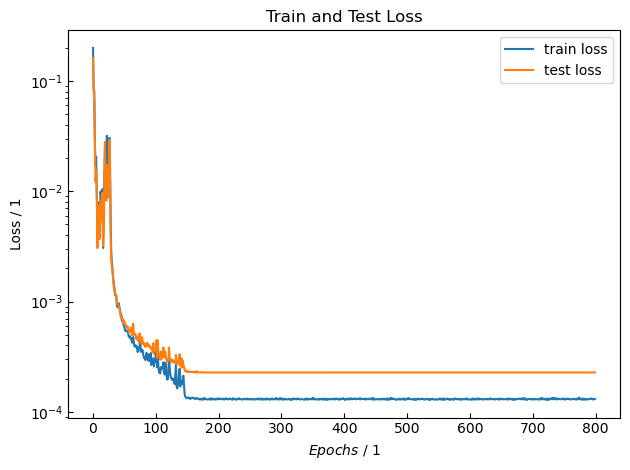

In [10]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = 'Loss / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Parity Plot

Training Dataset: R^2(H2) = 0.999882894018234 , R^2(NH3) = 0.9998557320249637
Test Dataset: R^2(H2) = 0.9997680973098491 , R^2(NH3) = 0.9997575839069931
Max Error Training: |x_H2 - x_H2,pred| = 0.006557893385132907 , |x_NH3 - x_NH3,pred| = 0.004957148903890818
Max Error Test: |x_H2 - x_H2,pred| = 0.008437081918614808 , |x_NH3 - x_NH3,pred| = 0.005524486127437889


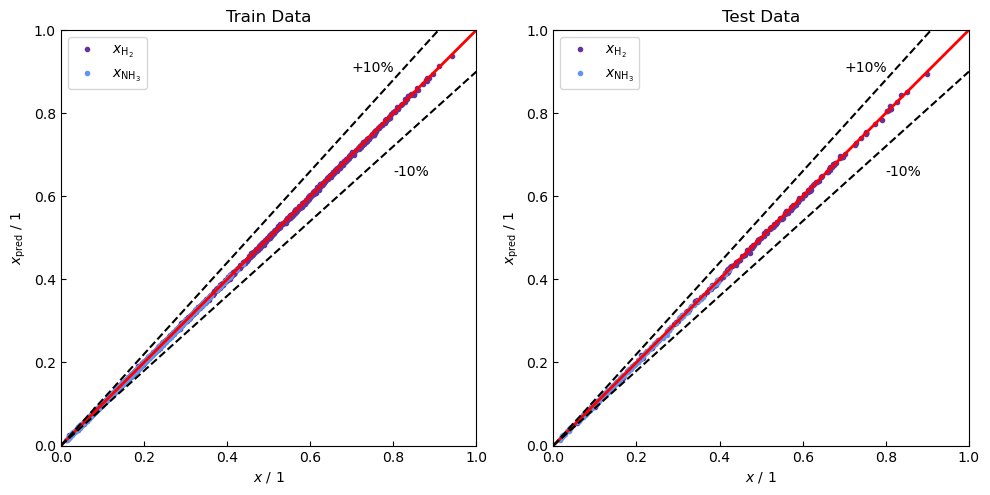

In [11]:
x_H2_real_norm = []
x_H2_pred_norm = []
x_NH3_real_norm = []
x_NH3_pred_norm = []
for (X,y) in train_dataloader:
    x_H2_real_norm = np.append(x_H2_real_norm, y[:,0].numpy())
    x_NH3_real_norm = np.append(x_NH3_real_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_x_H2)
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_x_NH3)

x_H2_real_test_norm = []
x_H2_pred_test_norm = []
x_NH3_real_test_norm = []
x_NH3_pred_test_norm = []
for (X,y) in test_dataloader:
    x_H2_real_test_norm = np.append(x_H2_real_test_norm, y[:,0].numpy())
    x_NH3_real_test_norm = np.append(x_NH3_real_test_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_test_norm = np.append(x_H2_pred_test_norm, help_x_H2)
    x_NH3_pred_test_norm = np.append(x_NH3_pred_test_norm, help_x_NH3)

x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()

x_H2_real_test = x_H2_real_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred_test = x_H2_pred_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real_test = x_NH3_real_test_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred_test = x_NH3_pred_test_norm * std_out[1].numpy() + mean_out[1].numpy()

print('Training Dataset: R^2(H2) =', r2(x_H2_real,x_H2_pred), ', R^2(NH3) =', r2(x_NH3_real,x_NH3_pred))
print('Test Dataset: R^2(H2) =', r2(x_H2_real_test,x_H2_pred_test), ', R^2(NH3) =', r2(x_NH3_real_test,x_NH3_pred_test))
print('Max Error Training: |x_H2 - x_H2,pred| =', max_error(x_H2_real, x_H2_pred), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real, x_NH3_pred))
print('Max Error Test: |x_H2 - x_H2,pred| =', max_error(x_H2_real_test, x_H2_pred_test), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real_test, x_NH3_pred_test))

# find the boundaries of X and Y values
bounds = (0,1)

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(x_H2_real, x_H2_pred, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[0].plot(x_NH3_real, x_NH3_pred, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[0].text(0.7, 0.9, '+10%')
ax[0].text(0.8, 0.65, '-10%')
ax[0].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')
ax[0].legend()
#ax[0].legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(x_H2_real_test, x_H2_pred_test, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[1].plot(x_NH3_real_test, x_NH3_pred_test, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[1].text(0.7, 0.9, '+10%')
ax[1].text(0.8, 0.65, '-10%')
ax[1].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')
ax[1].legend()


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

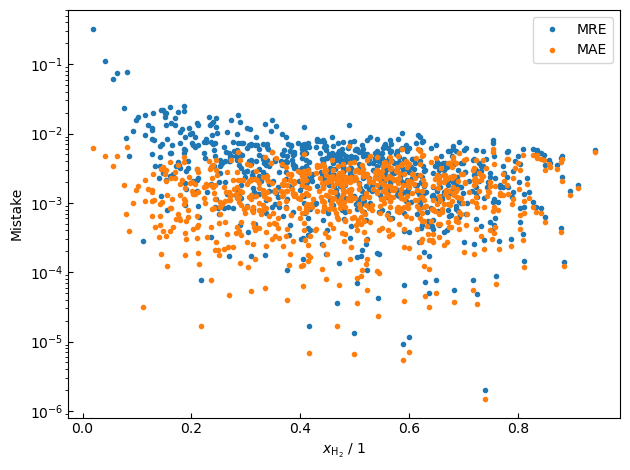

In [12]:
fig,ax = plt.subplots()
ax.semilogy(x_H2_real, abs((x_H2_pred - x_H2_real) / x_H2_real), '.', label = 'MRE')
ax.semilogy(x_H2_real, abs(x_H2_real-x_H2_pred), '.', label = 'MAE')
ax.set(xlabel = '$x \mathregular{_{H_2}}$ / 1', ylabel = 'Mistake')
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Fehler vs Epoch

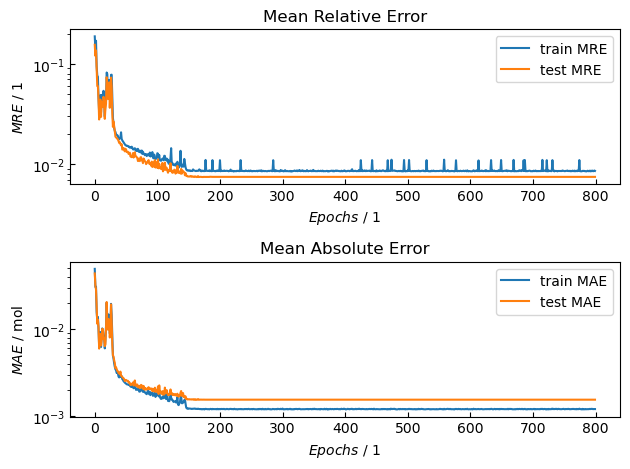

In [13]:
fig,ax = plt.subplots(2)
#fig.figsize=(12, 8)
ax[0].semilogy(train_MRE, label='train MRE')
ax[0].semilogy(test_MRE, label='test MRE')
ax[0].set_title("Mean Relative Error")
ax[0].set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].legend()

ax[1].semilogy(train_MAE, label='train MAE')
ax[1].semilogy(test_MAE, label='test MAE')
ax[1].set_title("Mean Absolute Error")
ax[1].set(xlabel = '$Epochs$ / 1', ylabel = '$MAE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].legend()

plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

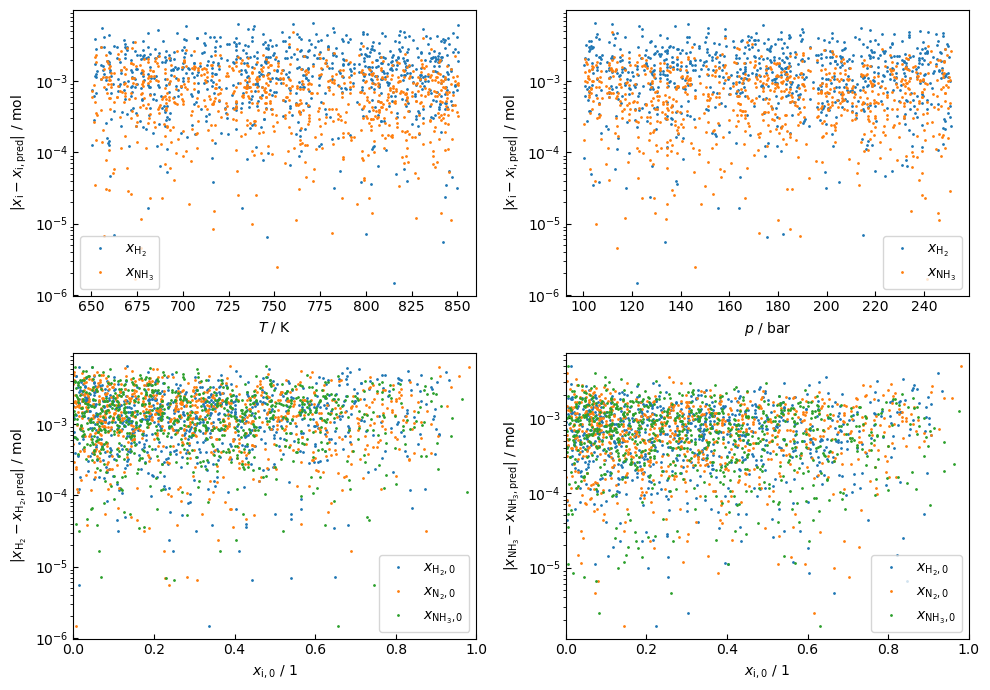

In [14]:
# mistake_H2 = []
# mistake_NH3 = []
x_H2_pred_norm = []
x_NH3_pred_norm = []
x_H2_real_norm = []
x_NH3_real_norm = []
param_T_norm = []
param_p_norm = []
param_x_H2_0_norm = []
param_x_N2_0_norm = []
param_x_NH3_0_norm = []
for X,y in train_dataloader:
#     help_mistake_H2, help_mistake_NH3 = (abs(y - net(X).detach().numpy())).T
#     mistake_H2 = np.append(mistake_H2, help_mistake_H2)
#     mistake_NH3 = np.append(mistake_NH3, help_mistake_NH3
    help_pred = net(X).detach().numpy()
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_pred[:,0])
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_pred[:,1])
    help_real = y.detach().numpy()
    x_H2_real_norm = np.append(x_H2_real_norm, help_real[:,0])
    x_NH3_real_norm = np.append(x_NH3_real_norm, help_real[:,1])
    param_T_norm = np.append(param_T_norm, X[:,0])
    param_p_norm = np.append(param_p_norm, X[:,1])
    param_x_H2_0_norm = np.append(param_x_H2_0_norm, X[:,2])
    param_x_N2_0_norm = np.append(param_x_N2_0_norm, X[:,3])
    param_x_NH3_0_norm = np.append(param_x_NH3_0_norm, X[:,4])

# print('x_H2:', x_H2_real_norm) #, x_H2_real_norm.dtype())
# print('x_H2_pred:', x_H2_pred_norm)
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()

mistake_H2 = abs(x_H2_real - x_H2_pred)
mistake_NH3 = abs(x_NH3_real - x_NH3_pred)

param_T = param_T_norm * std_in[0].numpy() + mean_in[0].numpy()
param_p = param_p_norm * std_in[1].numpy() + mean_in[1].numpy()
param_x_H2_0 = param_x_H2_0_norm * std_in[2].numpy() + mean_in[2].numpy()
param_x_N2_0 = param_x_N2_0_norm * std_in[3].numpy() + mean_in[3].numpy()
param_x_NH3_0 = param_x_NH3_0_norm * std_in[4].numpy() + mean_in[4].numpy()

# print('T:', param_T[0])
# print(len(param_T))
# print(param_T[0])

fig,ax = plt.subplots(2,2, figsize = (10, 7)) #gridspec_kw={'width_ratios': [1,1,1,1]})

ax[0,0].semilogy(param_T, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,0].semilogy(param_T, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,0].set(xlabel = '$T$ / K', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,0].legend()

ax[0,1].semilogy(param_p, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,1].semilogy(param_p, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,1].set(xlabel = '$p$ / bar', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,1].legend()

ax[1,0].semilogy(param_x_H2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,0].semilogy(param_x_N2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,0].semilogy(param_x_NH3_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,0].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{H_2}} - x\mathregular{_{H_2,pred}}$| / mol')
ax[1,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,0].set(xlim = (0,1))
ax[1,0].legend()

ax[1,1].semilogy(param_x_H2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,1].semilogy(param_x_N2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,1].semilogy(param_x_NH3_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,1].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{NH_3}} - x\mathregular{_{NH_3,pred}}$| / mol')
ax[1,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,1].set(xlim = (0,1))
ax[1,1].legend()

plt.tight_layout()
plt.show()

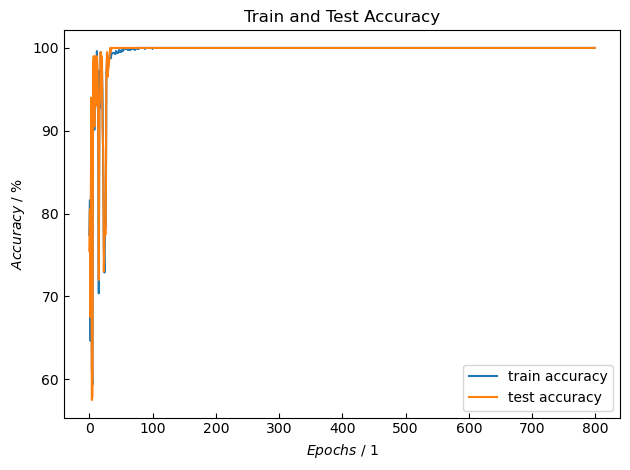

In [15]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Debugging Hilfe

In [16]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y)
    print(net(X))
    break

tensor([[-9.3820e-01,  1.9071e-01,  4.2470e-01, -6.1213e-01,  2.0885e-01],
        [-8.1606e-01,  2.1853e-01, -2.0454e-01,  4.5452e-01, -2.6382e-01],
        [ 1.3420e+00,  1.0437e+00, -7.5648e-01,  5.5882e-01,  1.7124e-01],
        [ 9.0468e-01, -9.3573e-01, -1.0592e+00,  2.1913e+00, -1.2002e+00],
        [ 4.6592e-01,  1.2939e+00,  5.9378e-01, -3.3471e-01, -2.4063e-01],
        [-1.4235e+00,  5.8443e-01, -2.2827e-01,  4.0609e-01, -1.9104e-01],
        [ 1.2847e-01, -1.3181e+00, -8.6613e-01, -9.3356e-01,  1.8042e+00],
        [-9.2755e-01,  4.7059e-01, -9.4356e-01,  9.3635e-02,  8.3029e-01],
        [ 3.7597e-01,  1.5015e+00, -8.2947e-01,  3.6607e-01,  4.3988e-01],
        [-1.2624e+00, -1.4083e+00, -1.4108e+00,  2.5834e+00, -1.2559e+00],
        [-5.1265e-01,  9.0194e-01,  1.2347e-01, -1.4353e-01,  2.5528e-02],
        [ 8.7705e-01,  2.3089e-01,  4.1486e-01, -1.8945e-01, -2.1351e-01],
        [ 5.5718e-03,  8.5302e-01, -1.1338e+00,  6.8181e-01,  4.1580e-01],
        [ 4.4469e-01, -1.

#### Einblick in Netzwerk

In [17]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([[-0.0522,  0.1288, -0.3681,  0.1596, -0.3703],
         [ 0.1423, -0.4741, -0.0466, -0.3146, -0.1078],
         [ 0.3291,  0.0899, -0.1558, -0.2154,  0.0566],
         [-0.1951,  0.0598,  0.5525, -0.1679,  0.1189],
         [ 0.2906,  0.4241,  0.4167,  0.2010, -0.2471],
         [-0.4075,  0.1591, -0.2962,  0.2371, -0.2257],
         [ 0.1562,  0.1723,  0.2403, -0.4847, -0.0974],
         [ 0.1806, -0.2887, -0.1710, -0.2535,  0.3360],
         [-0.1162,  0.2851,  0.4805, -0.2950,  0.1994],
         [-0.2904,  0.1160, -0.1582,  0.0698, -0.0575],
         [ 0.4193,  0.4058,  0.1253,  0.0841,  0.3951],
         [ 0.3257, -0.4722, -0.0618,  0.3494,  0.2710],
         [ 0.0501,  0.5477, -0.0022,  0.2979, -0.3145],
         [ 0.3338, -0.1813, -0.4163,  0.1233, -0.1166],
         [ 0.0262, -0.2403,  0.1067,  0.1170, -0.1821],
         [ 0.3072, -0.3309,  0.2723,  0.3848, -0.3106],
         [-0.3823, -0.1978,  0.1301,  0.0973,  0.3248],
         [-0.3296, -0.176

In [18]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.3040, 0.7616, 0.1470, 0.7281, 0.0952],
        [0.8427, 0.9367, 0.4651, 0.7323, 0.8173]])
tensor([[-0.2296, -0.0926],
        [ 0.3352, -0.2604]], grad_fn=<AddmmBackward0>)


In [19]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [20]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    print(Lnorm(X))
    print((Lnorm(X.permute(0,2,1))).permute(0,2,1))
    print(Lnorm(X).mean(dim=0))
    print(Lnorm(X).mean(dim=1))


    break

tensor([[-0.8547,  0.0868, -1.3352,  0.2575,  1.0471],
        [-0.8378, -1.4711, -1.1141, -0.9800,  2.0950],
        [-0.5446,  0.4824, -0.2008, -0.7768,  0.9910],
        [ 0.5498,  0.7641,  0.0537, -1.3762,  1.3538],
        [-1.4023,  0.0802,  1.9006, -1.0370, -0.8053],
        [ 1.3873, -0.9041, -0.8673, -0.6064,  1.4709],
        [-1.3124, -0.4549, -0.6977,  0.7187, -0.0498],
        [ 1.3609,  0.6387, -0.4384,  0.3809,  0.0409],
        [-0.0896, -0.5045, -0.6923,  0.4943,  0.1742],
        [ 0.7875,  0.8012,  0.8098,  0.0512, -0.8470],
        [ 1.1893, -0.4103, -0.8378,  2.0083, -1.2305],
        [-0.2379,  0.1820, -0.2512,  0.4214, -0.1842],
        [ 1.3987,  0.9757,  0.6939, -0.6409, -0.0259],
        [-0.2482, -1.7039, -0.8631,  1.8846, -1.0791],
        [ 1.3626, -0.2621,  2.2885, -1.2217, -0.9972],
        [-0.1101, -1.0523,  0.8482, -0.5137, -0.3073],
        [-0.8352,  0.1776, -0.1793, -0.5101,  0.6974],
        [ 0.0491, -0.1389,  2.1761, -1.2780, -0.8294],
        [-

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3

#### Histogramme Verteilung von $xi$ und $x{_i}$

In [ ]:
#plt.hist(xi)
plt.hist(x_0[:,0],bins=100)
plt.hist(x_0[:,1],bins=100)

plt.show()